In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import copy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch import nn, optim
import torch.nn.functional as F
import argparse
import time
from tqdm import tqdm
import os
%matplotlib inline
from sklearn.decomposition import TruncatedSVD
from matplotlib import style

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
sns.set(style='dark')

In [4]:
df=pd.read_csv('normal dataset (no normalize).csv')
df.head()

MeasureMRM12  MeasureMRM30  MeasureMRM204  MeasureMRM205  MeasureMRM143  \
0          55.0          5.83            5.0            2.1           17.0   
1          55.0          5.83            5.0            2.1           17.0   
2          55.0          5.83            5.0            2.1           17.0   
3          55.0          5.83            5.0            2.1           17.0   
4          55.0          5.83            5.0            2.1           17.0   

   MeasureMRM187  MeasureMRM188  MeasureMRM144  ReservoirTemperature_c  \
0           55.5           25.7            0.0                    60.0   
1           55.5           25.7            0.0                    60.0   
2           55.5           25.7            0.0                    60.0   
3           55.5           25.7            0.0                    60.0   
4           55.5           25.7            0.0                    60.0   

   ProducingGOR_m3_t  LiquidViscosity  WeightedParticlesFactor_mg_l  
0               70.0             1.64                         132.0  
1               70.0             1.64                         132.0  
2               70.0             1.64                         132.0  
3               70.0             1.64                         132.0  
4               70.0             1.64                         132.0

In [5]:
anom=pd.read_csv('anomaly dataset (no normalize).csv')
anom.head()

MeasureMRM12  MeasureMRM30  MeasureMRM204  MeasureMRM205  MeasureMRM143  \
0          41.0          0.82            8.9           10.9            8.2   
1          42.0          0.83            0.0            0.0            8.3   
2          42.0          0.85            0.0            0.0            8.3   
3          41.0          0.83            8.0            9.6            8.3   
4          41.0          0.81            0.0            0.0            8.3   

   MeasureMRM187  MeasureMRM188  MeasureMRM144  ReservoirTemperature_c  \
0           66.0           26.1           51.0                    60.0   
1           66.0           26.5           51.0                    60.0   
2           66.0           27.0           51.0                    60.0   
3           66.0           27.0           51.0                    60.0   
4           66.0           27.9           51.0                    60.0   

   ProducingGOR_m3_t  LiquidViscosity  WeightedParticlesFactor_mg_l  
0              103.0             1.53                         125.0  
1              103.0             1.53                         125.0  
2              103.0             1.53                         125.0  
3              103.0             1.53                         125.0  
4              103.0             1.53                         125.0

In [6]:
df.columns

Index(['MeasureMRM12', 'MeasureMRM30', 'MeasureMRM204', 'MeasureMRM205',
       'MeasureMRM143', 'MeasureMRM187', 'MeasureMRM188', 'MeasureMRM144',
       'ReservoirTemperature_c', 'ProducingGOR_m3_t', 'LiquidViscosity',
       'WeightedParticlesFactor_mg_l'],
      dtype='object')

In [7]:
columns=df.columns

In [8]:
df.shape

(600701, 12)

In [9]:
df.head()

MeasureMRM12  MeasureMRM30  MeasureMRM204  MeasureMRM205  MeasureMRM143  \
0          55.0          5.83            5.0            2.1           17.0   
1          55.0          5.83            5.0            2.1           17.0   
2          55.0          5.83            5.0            2.1           17.0   
3          55.0          5.83            5.0            2.1           17.0   
4          55.0          5.83            5.0            2.1           17.0   

   MeasureMRM187  MeasureMRM188  MeasureMRM144  ReservoirTemperature_c  \
0           55.5           25.7            0.0                    60.0   
1           55.5           25.7            0.0                    60.0   
2           55.5           25.7            0.0                    60.0   
3           55.5           25.7            0.0                    60.0   
4           55.5           25.7            0.0                    60.0   

   ProducingGOR_m3_t  LiquidViscosity  WeightedParticlesFactor_mg_l  
0               70.0             1.64                         132.0  
1               70.0             1.64                         132.0  
2               70.0             1.64                         132.0  
3               70.0             1.64                         132.0  
4               70.0             1.64                         132.0

In [10]:
anom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48667 entries, 0 to 48666
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   MeasureMRM12                  48667 non-null  float64
 1   MeasureMRM30                  48667 non-null  float64
 2   MeasureMRM204                 48667 non-null  float64
 3   MeasureMRM205                 48667 non-null  float64
 4   MeasureMRM143                 48667 non-null  float64
 5   MeasureMRM187                 48667 non-null  float64
 6   MeasureMRM188                 48667 non-null  float64
 7   MeasureMRM144                 48667 non-null  float64
 8   ReservoirTemperature_c        48667 non-null  float64
 9   ProducingGOR_m3_t             48667 non-null  float64
 10  LiquidViscosity               48667 non-null  float64
 11  WeightedParticlesFactor_mg_l  48667 non-null  float64
dtypes: float64(12)
memory usage: 4.5 MB


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600701 entries, 0 to 600700
Data columns (total 12 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   MeasureMRM12                  600701 non-null  float64
 1   MeasureMRM30                  600701 non-null  float64
 2   MeasureMRM204                 600701 non-null  float64
 3   MeasureMRM205                 600701 non-null  float64
 4   MeasureMRM143                 600701 non-null  float64
 5   MeasureMRM187                 600701 non-null  float64
 6   MeasureMRM188                 600701 non-null  float64
 7   MeasureMRM144                 600701 non-null  float64
 8   ReservoirTemperature_c        600701 non-null  float64
 9   ProducingGOR_m3_t             600701 non-null  float64
 10  LiquidViscosity               600701 non-null  float64
 11  WeightedParticlesFactor_mg_l  600701 non-null  float64
dtypes: float64(12)
memory usage: 55.0 MB


In [12]:
from sklearn.preprocessing import MinMaxScaler

# Создаем экземпляр MinMaxScaler
scaler = MinMaxScaler()

# Нормализуем данные в датафрейме X
df = pd.DataFrame(scaler.fit_transform(df))
anom=pd.DataFrame(scaler.fit_transform(anom))

In [120]:
class encdataset(Dataset):
    def __init__(self, data, seq_len=1, batch_size=32):
        # data load
        self.data = data.drop('Failure', axis=1)
        self.features = self.data.values.astype(np.float32)
        self.n_samples, self.n_features = self.data.shape
        self.seq_len = seq_len
        self.train_df = self.data[0:576000]
        self.val_df = self.data[576000:]
        
        # создание датасета
        self.train_dataset = self.create_dataset(self.train_df, batch_size)
        self.val_dataset = self.create_dataset(self.val_df, batch_size)

    def create_dataset(self, data, batch_size):
        sequences = []
        for i in range(len(data) - self.seq_len + 1):
            sequence = data[i:i+self.seq_len].values  # Изменение здесь
            sequences.append(torch.from_numpy(sequence))
        dataset = DataLoader(sequences, batch_size=batch_size, shuffle=False)
        return dataset

    def __getitem__(self, index):
        return self.data.iloc[index]

    def __len__(self):
        return self.n_samples


In [121]:
dataset = encdataset(df)
train_loader = dataset.train_dataset
val_loader = dataset.val_dataset
seq_len = dataset.seq_len
n_features = dataset.n_features

In [122]:
# for batch in train_loader:
#     print(batch)
#     print(batch.shape)

In [123]:
seq_len

1

In [124]:
n_features

12

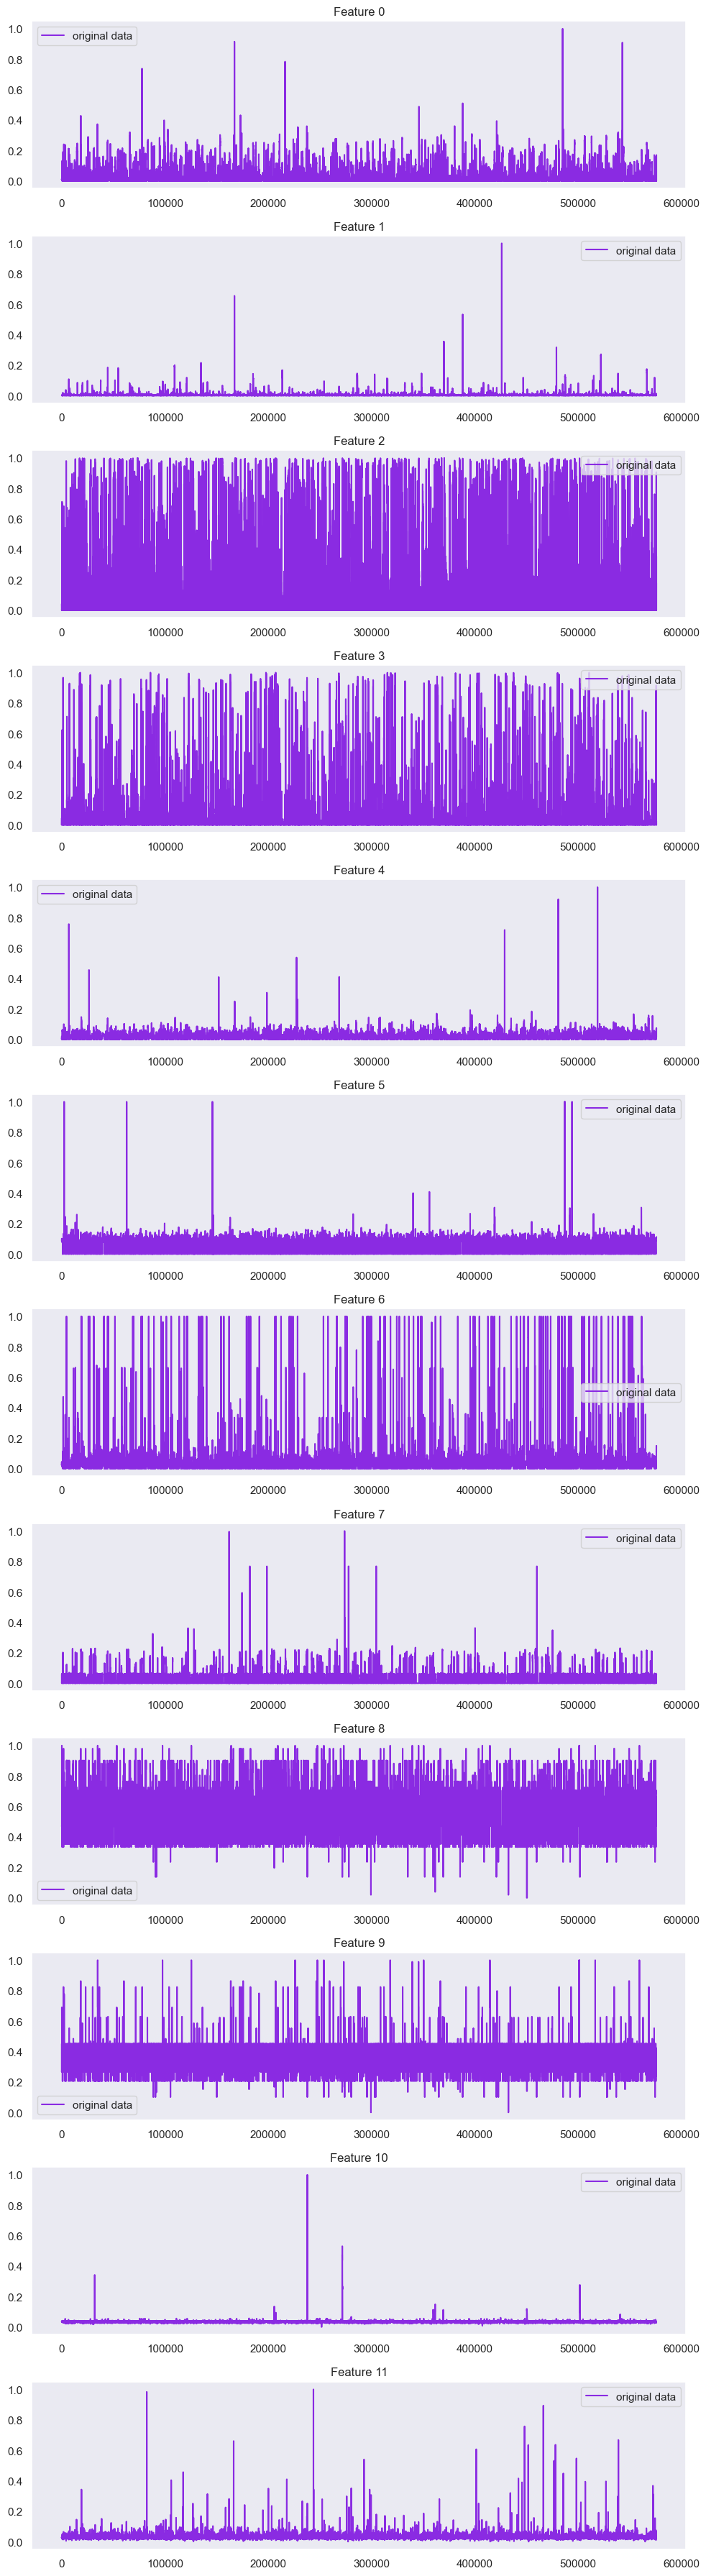

In [18]:
# 1. Извлечь данные из train_loader в виде numpy массива
train_data = []
for batch in train_loader:
    batch = batch.squeeze(1)  # убираем лишнее измерение
    batch = batch.numpy()  # преобразуем в numpy array
    for seq in batch:
        train_data.append(seq)
train_data = np.array(train_data)

# 2. Перестроить данные в подходящий формат для построения графиков
train_data = train_data.reshape(-1, seq_len, n_features)

# 3. Создать подграфики для каждой фичи
fig, axs = plt.subplots(n_features, 1, figsize=(10, n_features * 3))

# 4. Построить график для каждой фичи
for i in range(n_features):
    line, = axs[i].plot(train_data[:, 0, i], color='blueviolet', label='original data')
    for j in range(1, seq_len):
        axs[i].plot(train_data[:, j, i], color='blueviolet')
    axs[i].set_title(f'Feature {i}')
    axs[i].legend(handles=[line])  # Добавить легенду

plt.tight_layout()
plt.show()

In [13]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args('')

args.device = 'cuda' if torch.cuda.is_available() else 'cpu'

# ===== data loading ==== #
args.batch_size = 32

# ==== model capacity ==== #
args.n_layers = 1
args.embedding_dim = 128


# ==== regularization ==== #
# args.dropout = 0  # Установка значения dropout
args.use_bn = False  # batch normalization

# ==== optimizer & training  # ====
args.lr = 0.001
args.epoch = 180
args.patience = 20

In [14]:
class Encoder(nn.Module):
    def __init__(self, seq_len, n_features, args):
        super(Encoder, self).__init__()
        self.seq_len, self.n_features = seq_len, n_features
        self.hidden_dim = 2 * args.embedding_dim
        self.lstm1 = nn.LSTM(
            input_size=n_features,
            hidden_size=self.hidden_dim,
            num_layers=args.n_layers,
            batch_first=True,
            dtype=torch.float32
        ).to(args.device)
        self.lstm2 = nn.LSTM(
            input_size=self.hidden_dim,
            hidden_size=args.embedding_dim,
            num_layers=args.n_layers,
            batch_first=True,
            dtype=torch.float32
        ).to(args.device)

    def forward(self, x):
        x = x.to(args.device).to(torch.float32)
        batch_size = x.size(0)

        # print(f'ENCODER input dim: {x.shape}')
        x = x.reshape((batch_size, self.seq_len, self.n_features))
        # print(f'ENCODER reshaped dim: {x.shape}')
        x, (_, _) = self.lstm1(x)
        # print(f'ENCODER output lstm1 dim: {x.shape}')
        x, (hidden_n, _) = self.lstm2(x)
        # print(f'ENCODER output lstm2 dim: {x.shape}')
        # print(f'ENCODER hidden_n lstm2 dim: {hidden_n.shape}')
        # print(f'ENCODER hidden_n wants to be reshaped to : {(batch_size, args.embedding_dim)}')
        return hidden_n.reshape((batch_size, args.embedding_dim))

class Decoder(nn.Module):
    def __init__(self, seq_len, n_features, args):
        super(Decoder, self).__init__()
        self.seq_len, self.input_dim = seq_len, args.embedding_dim
        self.hidden_dim, self.n_features = 2 * args.embedding_dim, n_features
        self.lstm1 = nn.LSTM(
            input_size=args.embedding_dim,
            hidden_size=args.embedding_dim,
            num_layers=1,
            batch_first=True
        ).to(args.device)
        self.lstm2 = nn.LSTM(
            input_size=args.embedding_dim,
            hidden_size=self.hidden_dim,
            num_layers=1,
            batch_first=True
        ).to(args.device)
        self.output_layer = nn.Linear(self.hidden_dim, n_features).to(args.device)

    def forward(self, x):
        batch_size = x.size(0)
        x = x.to(args.device)
        # print(f'DECODER input dim: {x.shape}')
        x = x.repeat_interleave(self.seq_len, dim=0)
        # print(f'DECODER repeat dim: {x.shape}')
        x = x.reshape((batch_size, self.seq_len, self.input_dim))
        # print(f'DECODER reshaped dim: {x.shape}')
        x, (hidden_n, cell_n) = self.lstm1(x)
        # print(f'DECODER output rnn1 dim:/ {x.shape}')
        x, (hidden_n, cell_n) = self.lstm2(x)
        x = x.reshape((batch_size, self.seq_len, self.hidden_dim))
        return self.output_layer(x)

class LSTM_AUTO_ENCODER(nn.Module):
    def __init__(self, seq_len, n_features, args):
        super(LSTM_AUTO_ENCODER, self).__init__()
        self.seq_len = seq_len
        self.n_features = n_features
        self.encoder = Encoder(seq_len, n_features, args)
        self.decoder = Decoder(seq_len, n_features, args)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [15]:
class EarlyStopping:
    def __init__(self, patience=20, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

Проверка работоспособности модели

In [22]:
# encoder = Encoder(seq_len, n_features)

# for batch in train_loader:
#     output = encoder(batch)
#     print(f'Input shape: {batch.shape}')
#     print(f'Output shape: {output.shape}')
#     print('-' * 30)


In [23]:
# decoder = Decoder(seq_len, n_features)

# for batch in train_loader:
#     input_tensor = torch.randn(batch.size(0), args.embedding_dim)  # Создаем случайный входной тензор для декодера
#     output = decoder(input_tensor)
#     print(f'Input shape: {input_tensor.shape}')
#     print(f'Output shape: {output.shape}')
#     print('-' * 30)
#     break  # Выходим из цикла после первой итерации

In [24]:
# model = LSTM_AUTO_ENCODER(seq_len, n_features, args)

# for batch in train_loader:
#     input_tensor = batch
#     output = model(input_tensor)
#     print(f'Input shape: {input_tensor.shape}')
#     print(f'Output shape: {output.shape}')
#     print('-' * 30)
#     break

In [25]:
def train_model(model,train_loader, val_loader, n_epochs, n_features, args):
    early_stopping = EarlyStopping(patience=args.patience)
    # Установка режима обучения
    model.train()
    
    # Оптимизатор и функция потерь
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
    criterion = nn.MSELoss(reduction='sum').to(args.device)

    # История обучения
    history = {'train': [], 'val': []}

    # Переменная для отслеживания лучшей модели
    best_model_wts = None
    best_val_loss = float('inf')

    # Цикл обучения
    for epoch in range(1, n_epochs + 1):
        model = model.train()
        ts = time.time()
        train_losses = []

        # Создание DataLoader для обучающего набора данных
        train_loader = DataLoader(train_data, batch_size=args.batch_size, shuffle=True)
        train_loader = tqdm(train_loader, desc=f'Epoch {epoch}', leave=False)

        for seq_true in train_loader:
            optimizer.zero_grad()

            # Изменение формы входных данных на (batch_size, seq_len, n_features)
            seq_true = seq_true.reshape((-1, seq_len, n_features))
            seq_true = seq_true.float().to(args.device)

            seq_pred = model(seq_true)
    
            loss = criterion(seq_pred, seq_true)
            
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
            # Обновление tqdm
            train_loader.set_postfix(train_loss=np.mean(train_losses))

        val_losses = []
        model = model.eval()
        with torch.no_grad():
            for seq_true in val_loader:

                # Изменение формы входных данных на (batch_size, seq_len, n_features)
                seq_true = seq_true.reshape((-1, seq_len, n_features))
                seq_true = seq_true.float().to(args.device)

                seq_pred = model(seq_true)

                loss = criterion(seq_pred, seq_true)

                val_losses.append(loss.item())
        te = time.time()
        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)
        history['train'].append(train_loss)
        history['val'].append(val_loss)
        
        # Вызов EarlyStopping и проверка на необходимость остановки
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print(f"Early stopping at epoch {epoch}")
            break
        
        print(f"Epoch: {epoch}  train loss: {train_loss}  val loss: {val_loss}  time: {te-ts} ")
        # Построение графиков каждые 10 эпох
        if epoch % 10 == 0:
            # 1. Извлечь данные из val_loader в виде numpy массива
            val_data_np = torch.cat([batch for batch in val_loader], dim=0).detach().cpu().numpy()

            # 2. Перестроить данные в подходящий формат для построения графиков
            val_data_np = val_data_np.reshape(-1, seq_len, n_features)

            # 3. Получить предсказания модели
            preds = []
            with torch.no_grad():
                model = model.eval()
                for seq_true in val_loader:
                    seq_true = seq_true.to(args.device)
                    seq_true = seq_true.reshape((-1, seq_len, n_features))

                    seq_pred = model(seq_true)
                    preds.append(seq_pred.cpu().numpy())
            preds = np.concatenate(preds, axis=0)

            # 4. Создать подграфики для каждой фичи
            fig, axs = plt.subplots(n_features, 1, figsize=(10, n_features * 3))

            # 5. Построить график для каждой фичи
            for i in range(n_features):
                line1, = axs[i].plot(val_data_np[:, 0, i], color='blueviolet', label='original data')

                line2, = axs[i].plot(preds[:, 0, i], color='orange', label='predictions')
                for j in range(1, seq_len):
                    axs[i].plot(val_data_np[:, j, i], color='blueviolet')
                    axs[i].plot(preds[:, j, i], color='orange')
                axs[i].set_title(f'Feature {i}')
                axs[i].legend(handles=[line1, line2])

            plt.tight_layout()
            plt.show()

        # Сохранение лучшей модели
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

    # Загрузка весов лучшей модели
    model.load_state_dict(best_model_wts)

    return model.eval(), history


In [26]:
model = LSTM_AUTO_ENCODER(seq_len=seq_len, n_features=n_features, args=args)
model = model.to(args.device)
model

LSTM_AUTO_ENCODER(
  (encoder): Encoder(
    (lstm1): LSTM(12, 256, batch_first=True)
    (lstm2): LSTM(256, 128, batch_first=True)
  )
  (decoder): Decoder(
    (lstm1): LSTM(128, 128, batch_first=True)
    (lstm2): LSTM(128, 256, batch_first=True)
    (output_layer): Linear(in_features=256, out_features=12, bias=True)
  )
)

Epoch: 1  train loss: 0.12171200756773598  val loss: 0.0034422106458654703  time: 157.6074481010437 


Epoch: 2  train loss: 0.0031832612777102946  val loss: 0.0011717329193672668  time: 156.49688053131104 


Epoch: 3  train loss: 0.00208887460856042  val loss: 0.008029360521236106  time: 155.76331067085266 


Epoch: 4  train loss: 0.00145517638320881  val loss: 0.00016511635773607794  time: 153.91446161270142 


Epoch: 5  train loss: 0.001028614353085383  val loss: 0.00021219422719719576  time: 152.86753225326538 


Epoch: 6  train loss: 0.000856749358066534  val loss: 0.0004865316061179818  time: 154.19444274902344 


Epoch: 7  train loss: 0.0007696456139789613  val loss: 0.001210953604259258  time: 153.62283611297607 


Epoch: 8  train loss: 0.0006539546512046097  val loss: 0.00023987458264294602  time: 154.029221534729 


Epoch: 9  train loss: 0.000630733449024774  val loss: 0.0005632156194860256  time: 154.38833737373352 


Epoch: 10  train loss: 0.0005899027298650657  val loss: 0.000671689144823591  time: 154.34025025367737 


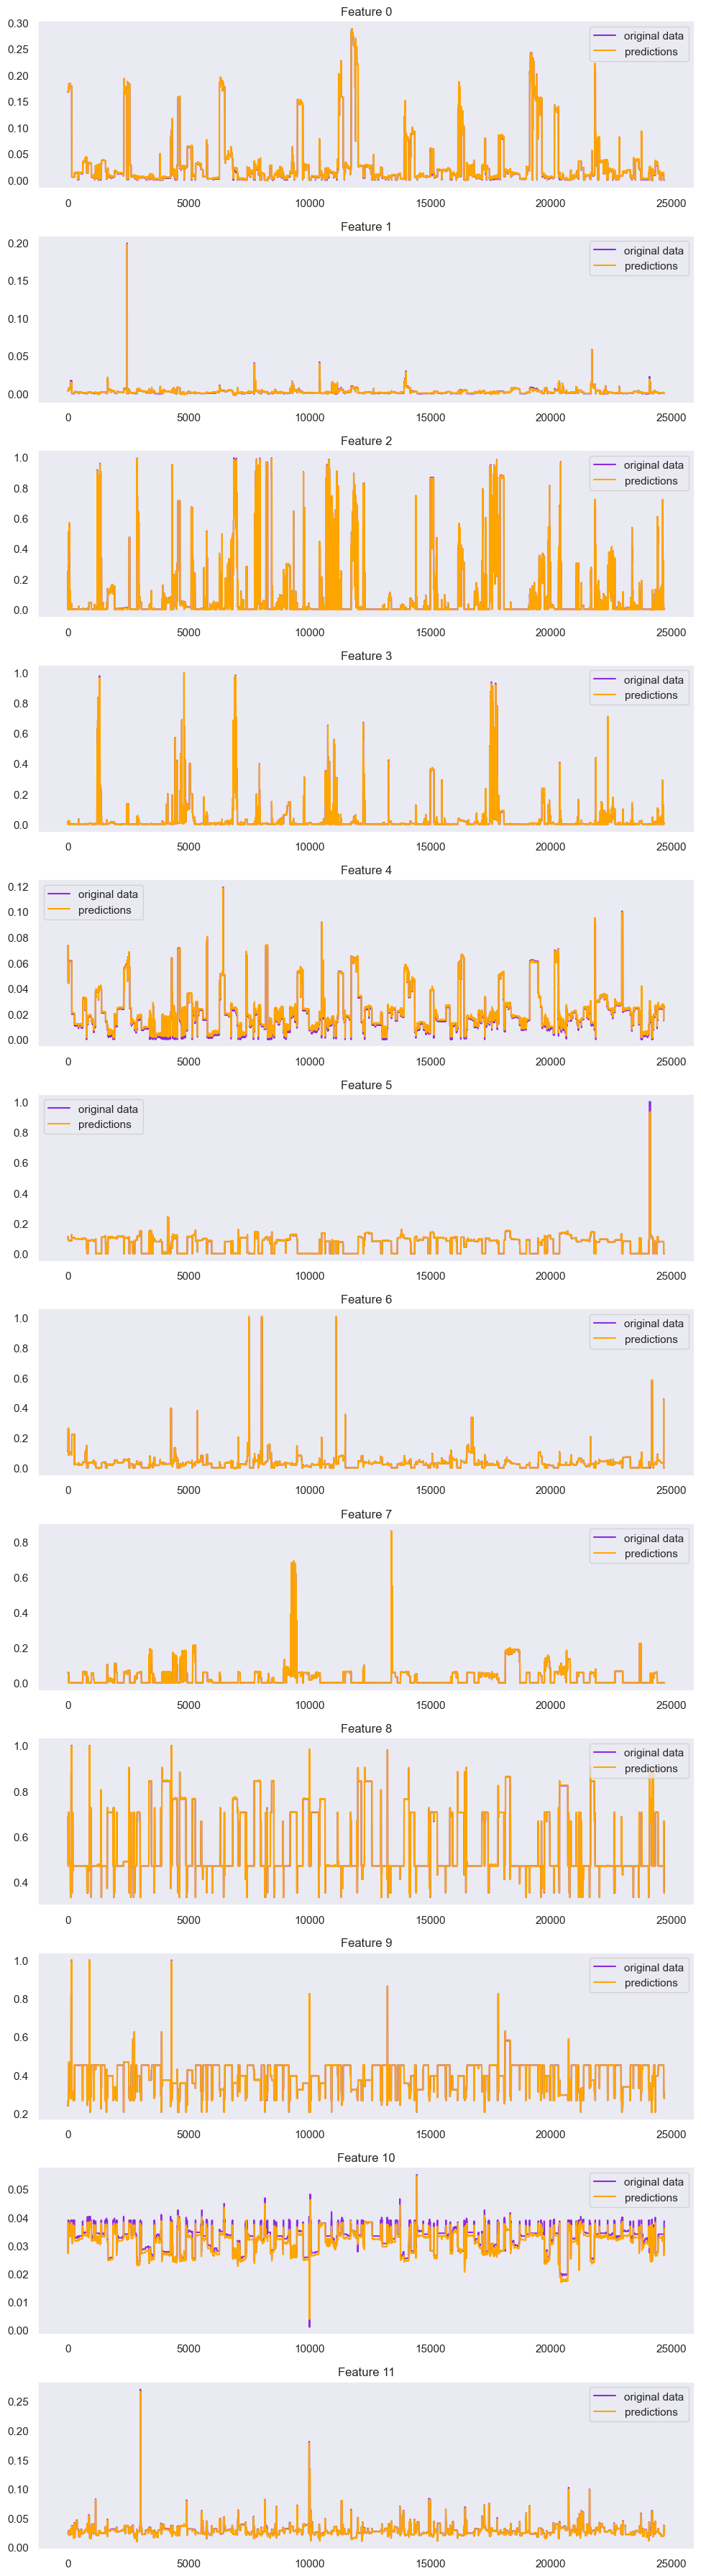

Epoch: 11  train loss: 0.0005165158296255565  val loss: 0.001102818578156405  time: 149.4867491722107 


Epoch: 12  train loss: 0.0004991434612226537  val loss: 0.0006902579422215292  time: 149.52438640594482 


Epoch: 13  train loss: 0.00046846256601202187  val loss: 0.000269620210184573  time: 149.06584310531616 


Epoch: 14  train loss: 0.0004289315102719734  val loss: 0.0005350921728583101  time: 149.27516412734985 


Epoch: 15  train loss: 0.0004277706859205258  val loss: 0.000741776305384769  time: 148.99830603599548 


Epoch: 16  train loss: 0.00039770984402316066  val loss: 0.0003510552878227535  time: 149.34118247032166 


Epoch: 17  train loss: 0.00039655535146610214  val loss: 0.0007082027940117571  time: 149.35925960540771 


Epoch: 18  train loss: 0.00038373069661550593  val loss: 0.0003713384349827056  time: 149.38747668266296 


Epoch: 19  train loss: 0.00036022660052877753  val loss: 0.00013184120710136928  time: 149.94166326522827 


Epoch: 20  train loss: 0.00035041050166698064  val loss: 0.0002089612480018718  time: 149.5032081604004 


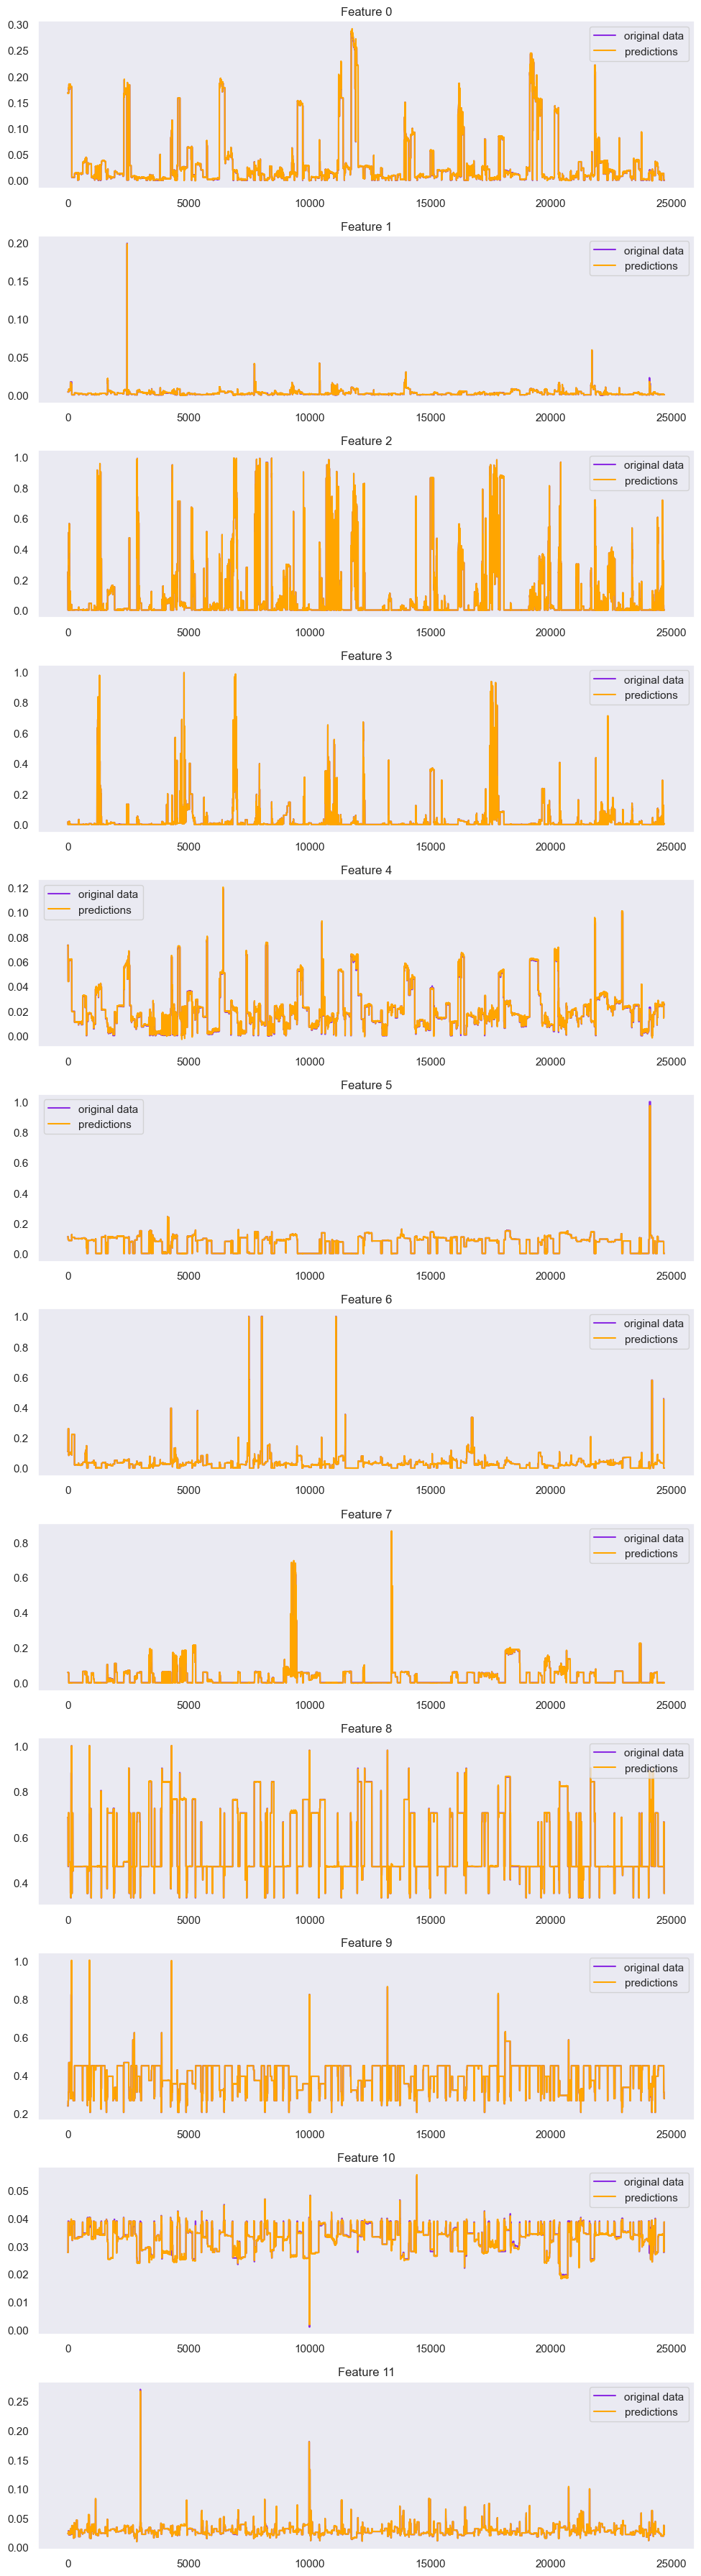

Epoch: 21  train loss: 0.0003446643976281444  val loss: 0.0003193170158045488  time: 155.1940474510193 


Epoch: 22  train loss: 0.00031843469374830927  val loss: 0.00011554629331769574  time: 150.47347044944763 


Epoch: 23  train loss: 0.0003362760972388262  val loss: 0.00013081177063105159  time: 150.90793633460999 


Epoch: 24  train loss: 0.0003220444186458735  val loss: 8.046930148159944e-05  time: 150.15172386169434 


Epoch: 25  train loss: 0.00030129789372363623  val loss: 0.0002481475991342902  time: 150.5992567539215 


Epoch: 26  train loss: 0.00030345725779938625  val loss: 0.00021681462483005712  time: 149.4248490333557 


Epoch: 27  train loss: 0.0002792770013636275  val loss: 0.00010805019428988211  time: 150.19334149360657 


Epoch: 28  train loss: 0.00027313898727859647  val loss: 0.0005090823217403383  time: 149.64663982391357 


Epoch: 29  train loss: 0.000271099498463122  val loss: 0.00010132337243406778  time: 150.91051030158997 


Epoch: 30  train loss: 0.0002669719929664198  val loss: 0.0001537351720238275  time: 150.63150835037231 


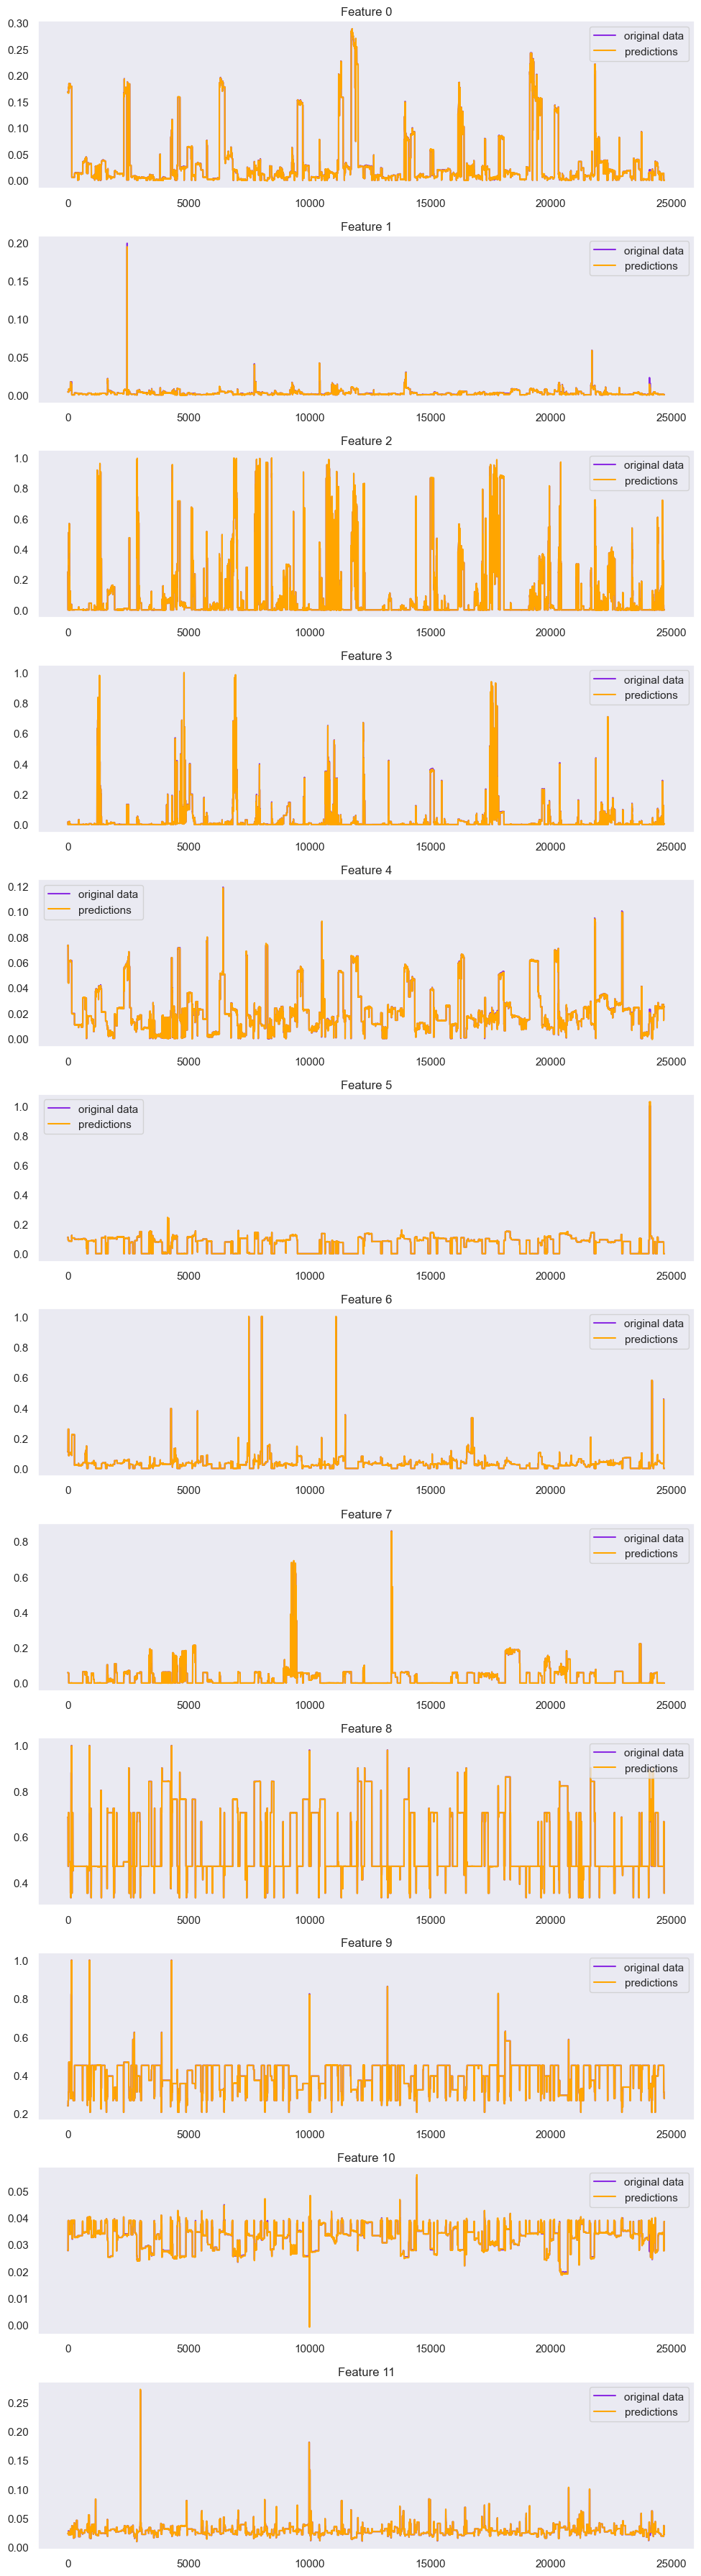

Epoch: 31  train loss: 0.00026301044759030547  val loss: 0.00020442521473469148  time: 150.05783796310425 


Epoch: 32  train loss: 0.0002470619759846563  val loss: 0.00033176394511575037  time: 150.51046991348267 


Epoch: 33  train loss: 0.0002598528230761177  val loss: 0.00011241165707761333  time: 150.93302965164185 


Epoch: 34  train loss: 0.00024798172850205445  val loss: 0.0002896928424410447  time: 151.40072679519653 


Epoch: 35  train loss: 0.0002449234064563623  val loss: 0.00015166598434120126  time: 151.11945223808289 


Epoch: 36  train loss: 0.00022982688434396753  val loss: 8.335633203029118e-05  time: 150.61288237571716 


Epoch: 37  train loss: 0.00024256991994464747  val loss: 0.00017060681279000575  time: 150.86819052696228 


Epoch: 38  train loss: 0.00022761584341601015  val loss: 0.00014743180151522046  time: 150.24306535720825 


Epoch: 39  train loss: 0.00022929726018668993  val loss: 0.00018720021903320485  time: 150.5932321548462 


Epoch: 40  train loss: 0.0002153155017921967  val loss: 0.00015716101309200912  time: 150.59666872024536 


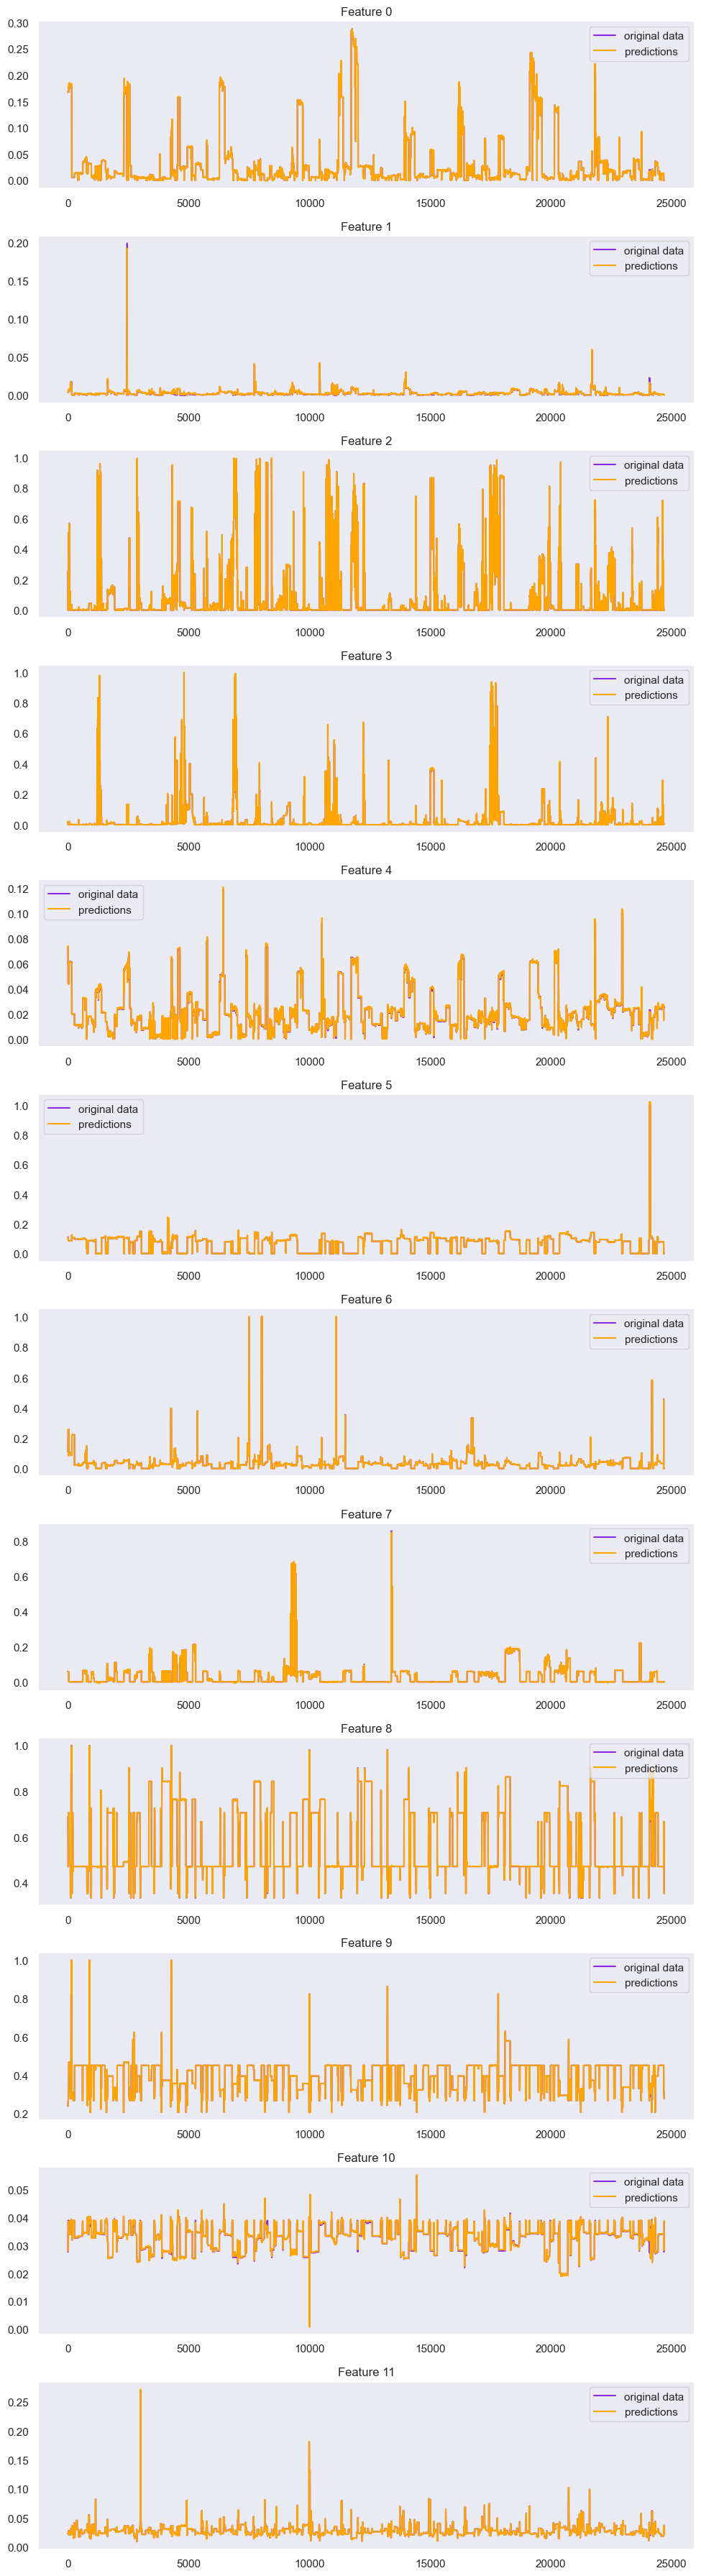

Epoch: 41  train loss: 0.00022097654700837664  val loss: 5.582718300158159e-05  time: 151.12452363967896 


Epoch: 42  train loss: 0.0002207989126318858  val loss: 0.00020258958393430706  time: 150.68738079071045 


Epoch: 43  train loss: 0.00021536783574427115  val loss: 0.00033006658355080084  time: 151.1453058719635 


Epoch: 44  train loss: 0.0002021479795954393  val loss: 7.85414747503161e-05  time: 150.65027594566345 


Epoch: 45  train loss: 0.00021775910519080652  val loss: 0.0007659277683494907  time: 150.2291100025177 


Epoch: 46  train loss: 0.00020926659595599833  val loss: 0.00019169799905218915  time: 150.64747643470764 


Epoch: 47  train loss: 0.00020532049900425086  val loss: 0.00012752591496061443  time: 155.72599482536316 


Epoch: 48  train loss: 0.000206348127094821  val loss: 0.0003408169329205695  time: 164.9757091999054 


Epoch: 49  train loss: 0.0002019163083608267  val loss: 0.0002489772425150397  time: 151.61978149414062 


Epoch: 50  train loss: 0.00019778377522617222  val loss: 0.0001455910652368751  time: 151.47176933288574 


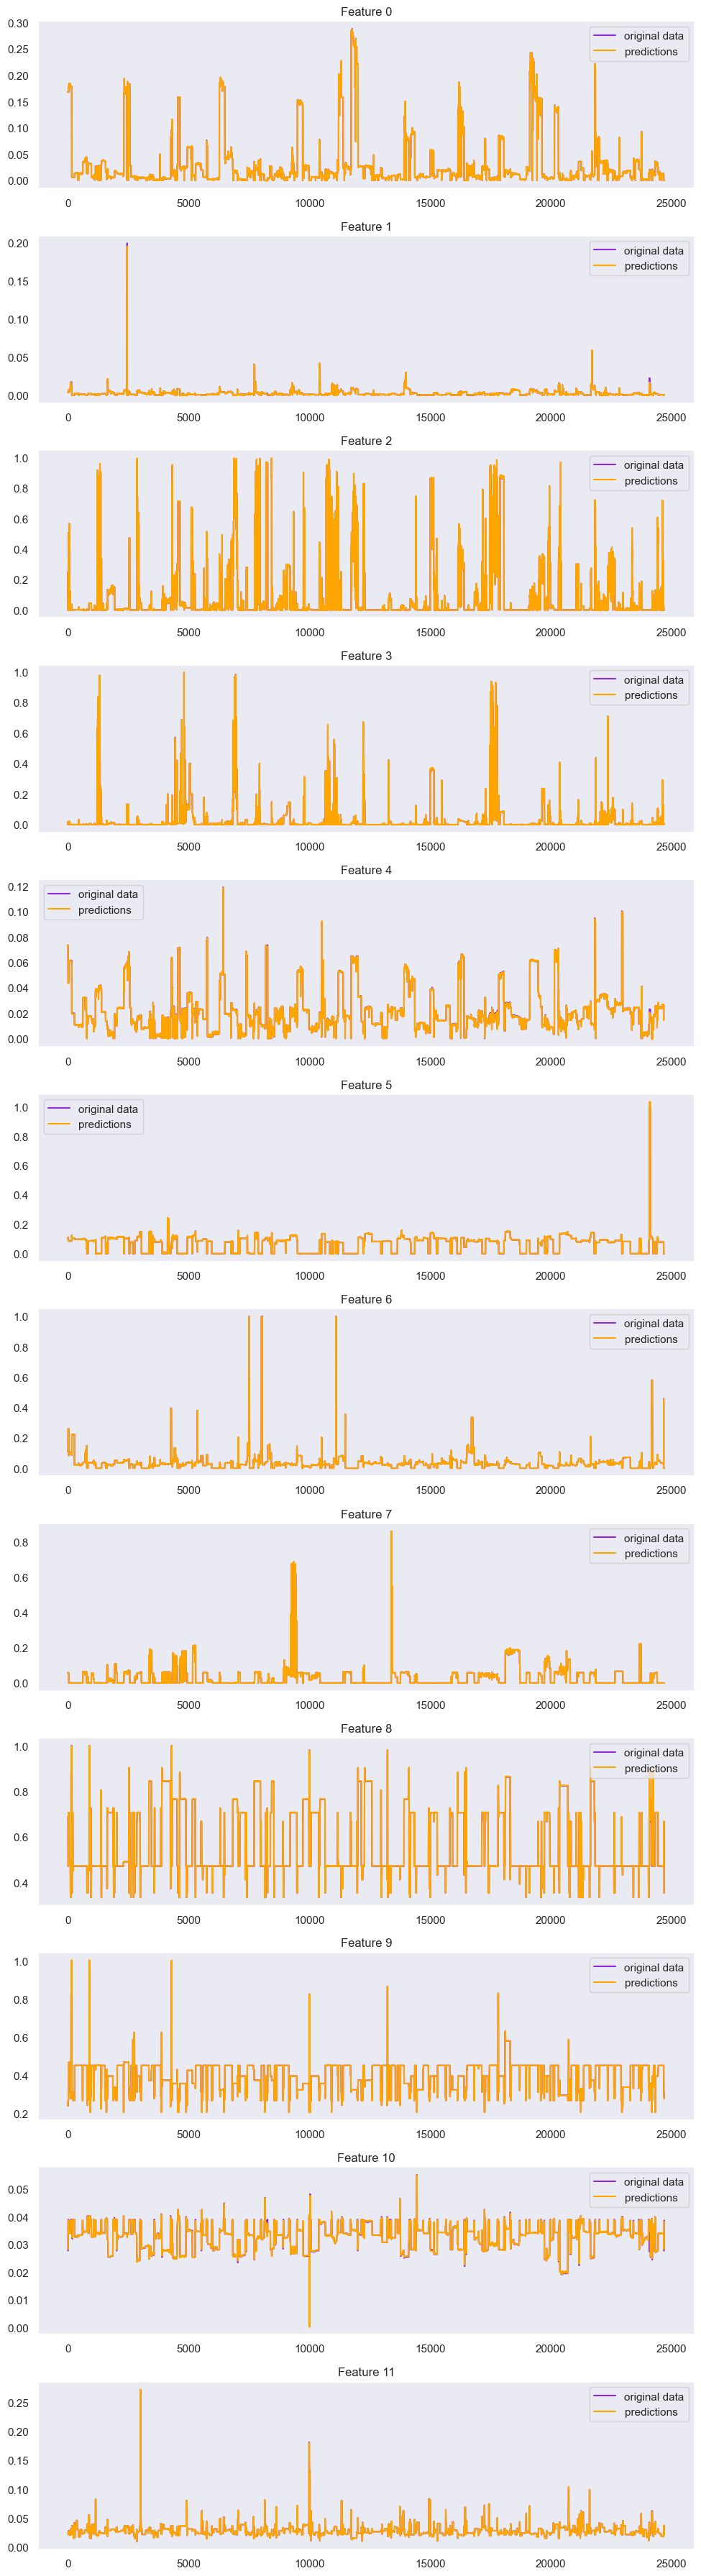

Epoch: 51  train loss: 0.00019415885308651722  val loss: 0.00012554158584683235  time: 150.1216332912445 


Epoch: 52  train loss: 0.00020004506671264405  val loss: 0.0001058428074559276  time: 150.44833326339722 


Epoch: 53  train loss: 0.00018792597066127808  val loss: 8.681066725999473e-05  time: 150.82414937019348 


Epoch: 54  train loss: 0.0001848071624293526  val loss: 7.136569785147606e-05  time: 150.79868841171265 


Epoch: 55  train loss: 0.00018843280003865302  val loss: 0.00018210790861048924  time: 150.46625518798828 


Epoch: 56  train loss: 0.00018392104394256926  val loss: 0.0001703558613432831  time: 151.53222703933716 


Epoch: 57  train loss: 0.00018212206459576112  val loss: 0.0002375830282558433  time: 151.53770065307617 


Epoch: 58  train loss: 0.0001827974850717611  val loss: 5.101286210788792e-05  time: 150.6608326435089 


Epoch: 59  train loss: 0.00017801581607535707  val loss: 0.00038250502503601146  time: 151.51845741271973 


Epoch: 60  train loss: 0.00018204790980310768  val loss: 6.350621650427725e-05  time: 150.56527757644653 


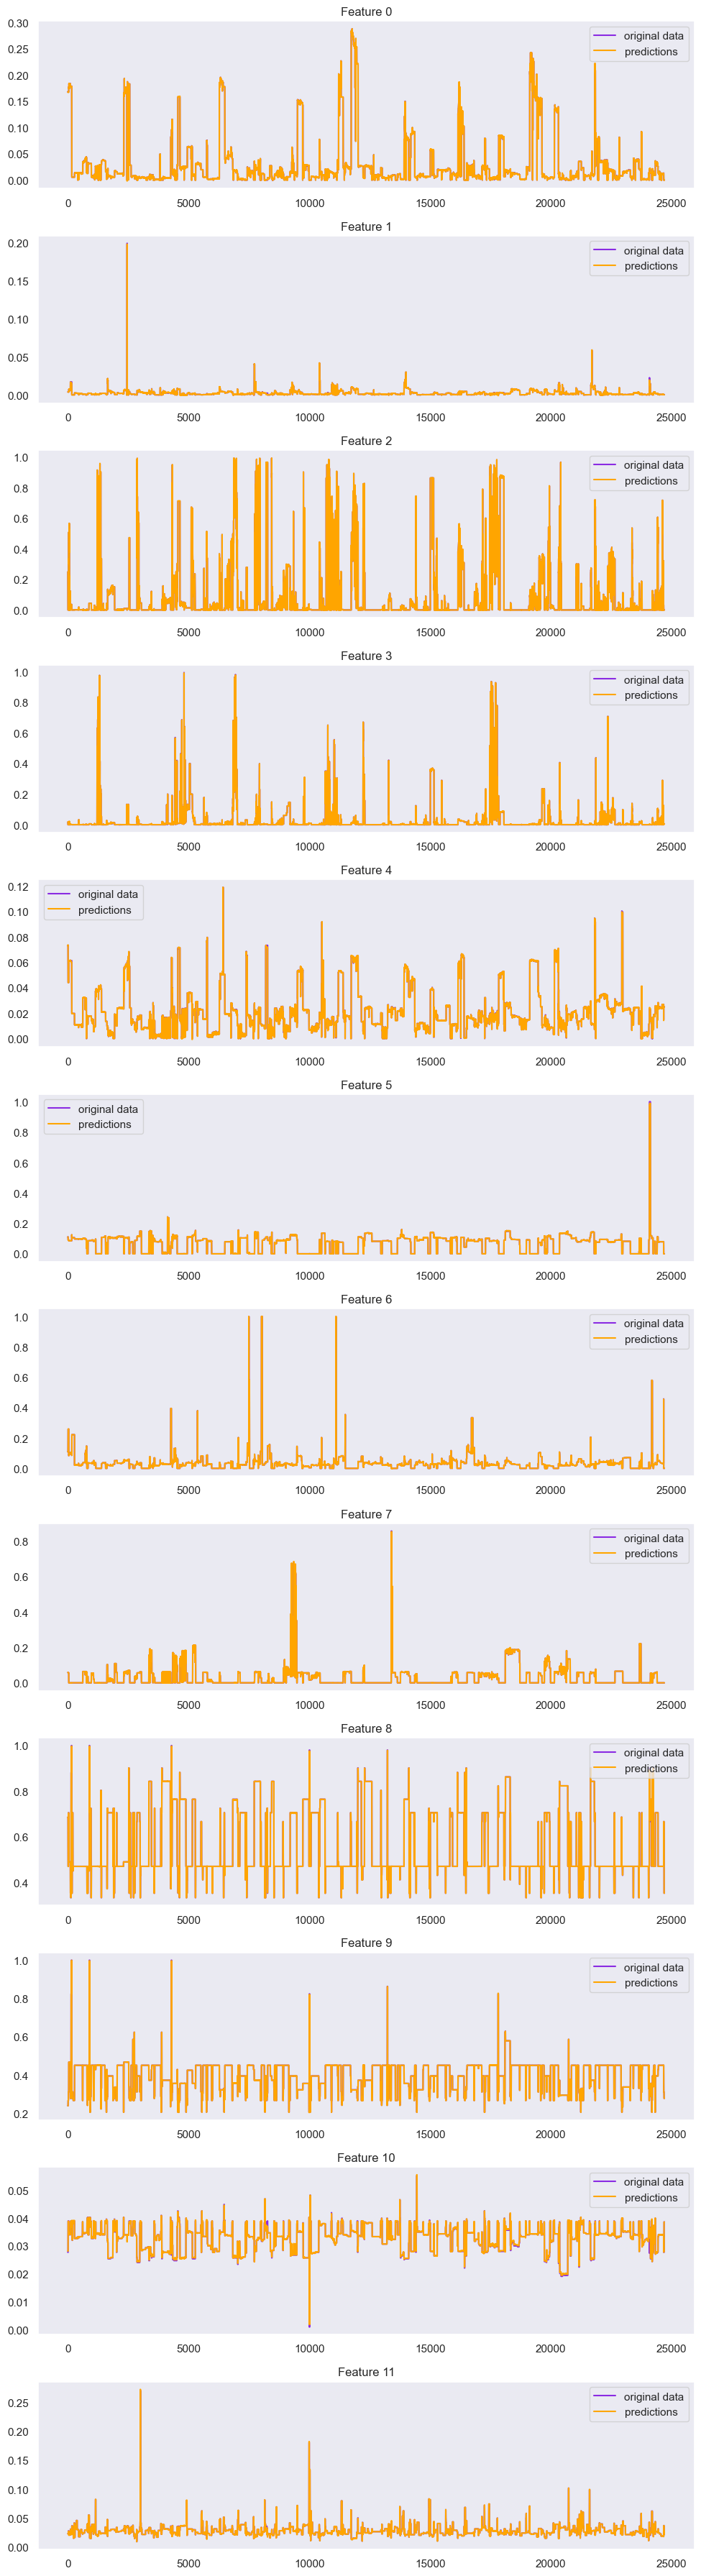

Epoch: 61  train loss: 0.00017617194180603394  val loss: 7.202816535880469e-05  time: 151.24209880828857 


Epoch: 62  train loss: 0.00017897055053567277  val loss: 9.251260351664626e-05  time: 151.09823942184448 


Epoch: 63  train loss: 0.00017409733538079308  val loss: 7.616906059929486e-05  time: 150.88718438148499 


Epoch: 64  train loss: 0.00016564755435375547  val loss: 8.886906264522556e-05  time: 150.5620801448822 


Epoch: 65  train loss: 0.00017982077932179486  val loss: 0.00013645626236235246  time: 150.36026263237 


Epoch: 66  train loss: 0.00016290823146042992  val loss: 8.023940912669203e-05  time: 150.76565432548523 


Epoch: 67  train loss: 0.00016373325832859742  val loss: 0.00010122419610659261  time: 152.79567646980286 


Epoch: 68  train loss: 0.0001698221922537818  val loss: 0.0002723997276021277  time: 151.10725808143616 


Epoch: 69  train loss: 0.00017022164081355288  val loss: 6.521218253529447e-05  time: 150.79364228248596 


Epoch: 70  train loss: 0.00015914695046477493  val loss: 7.639466428907401e-05  time: 150.5080966949463 


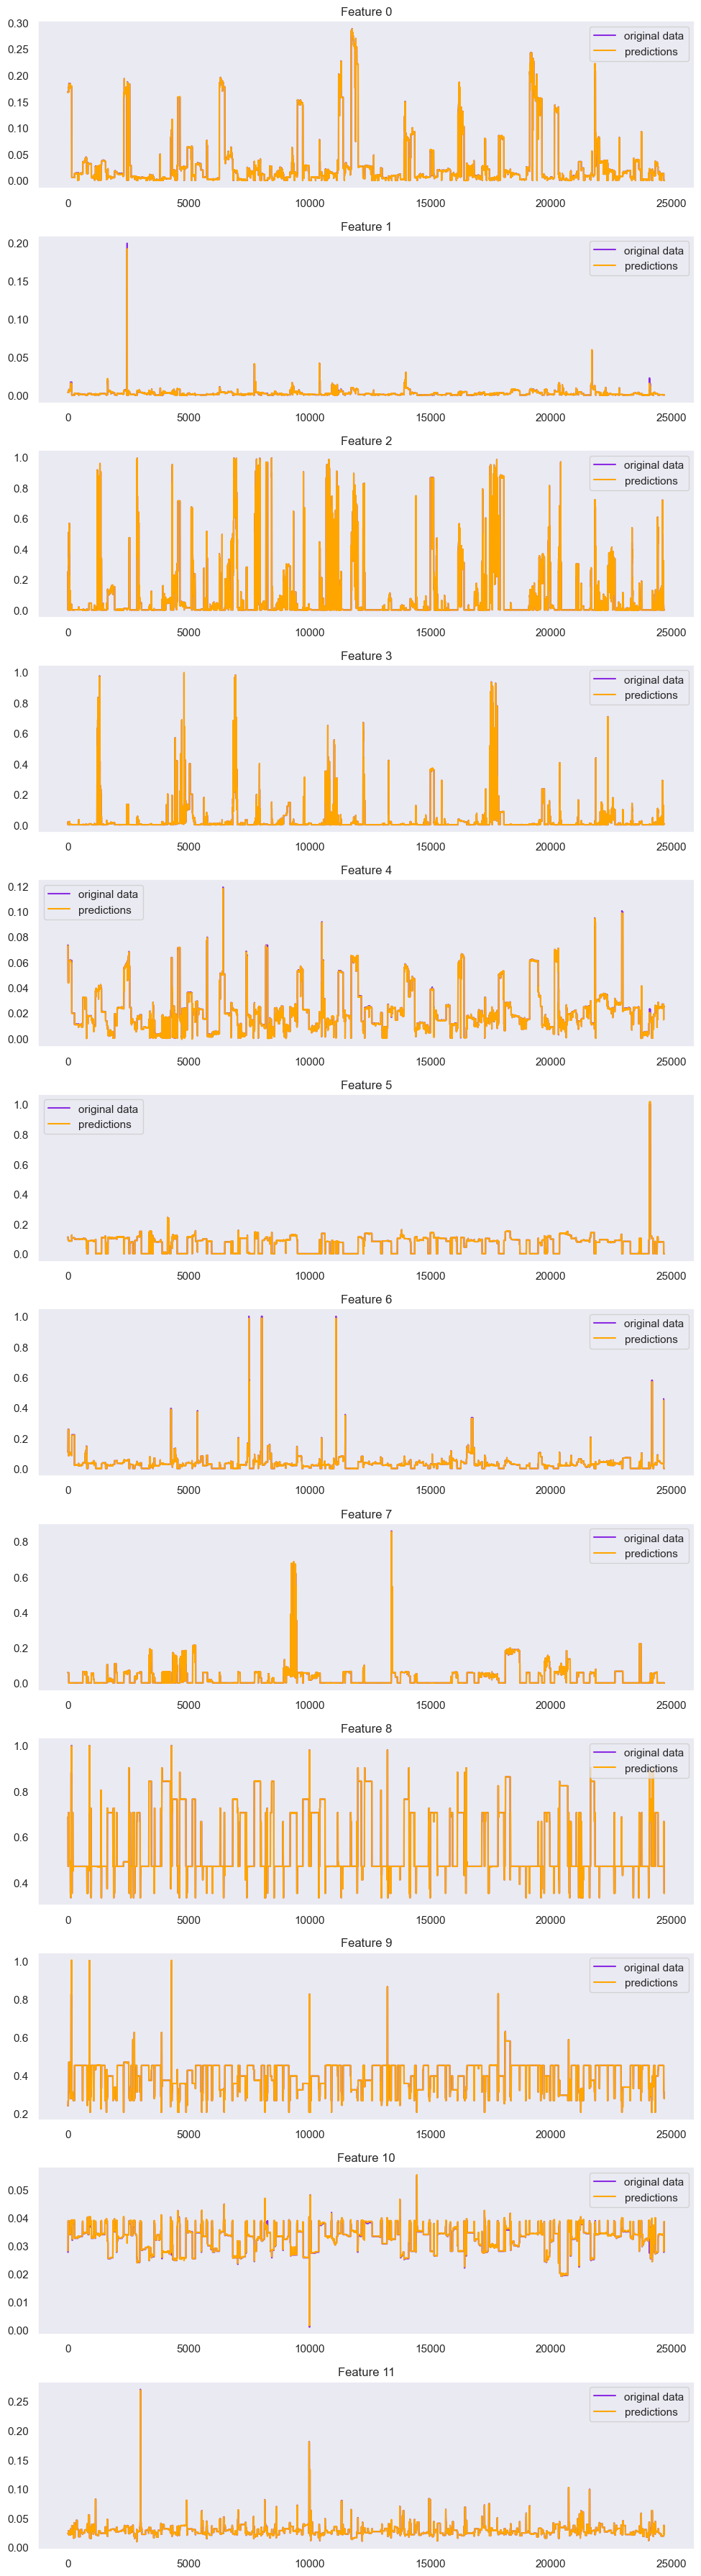

Epoch: 71  train loss: 0.00016373180491069029  val loss: 7.113259620019595e-05  time: 151.92270612716675 


Epoch: 72  train loss: 0.0001560932527761199  val loss: 9.272280105595606e-05  time: 151.40663528442383 


Epoch: 73  train loss: 0.00015880081105759322  val loss: 0.00020109948146500048  time: 151.0679326057434 


Epoch: 74  train loss: 0.00015849880311851746  val loss: 0.00011903000711594208  time: 151.10843801498413 


Epoch: 75  train loss: 0.00016112578241528455  val loss: 8.913493488267666e-05  time: 150.92339992523193 


Epoch: 76  train loss: 0.00015967433727711168  val loss: 3.858063404487754e-05  time: 150.97559332847595 


Epoch: 77  train loss: 0.00015138090659785221  val loss: 0.0001469224566106918  time: 150.78654789924622 


Epoch: 78  train loss: 0.00014864745189637082  val loss: 0.00021913656624155683  time: 151.63514375686646 


Epoch: 79  train loss: 0.00015049572260219672  val loss: 0.00024307784382556987  time: 152.43311858177185 


Epoch: 80  train loss: 0.00015519561720298548  val loss: 4.463318354355862e-05  time: 153.11105513572693 


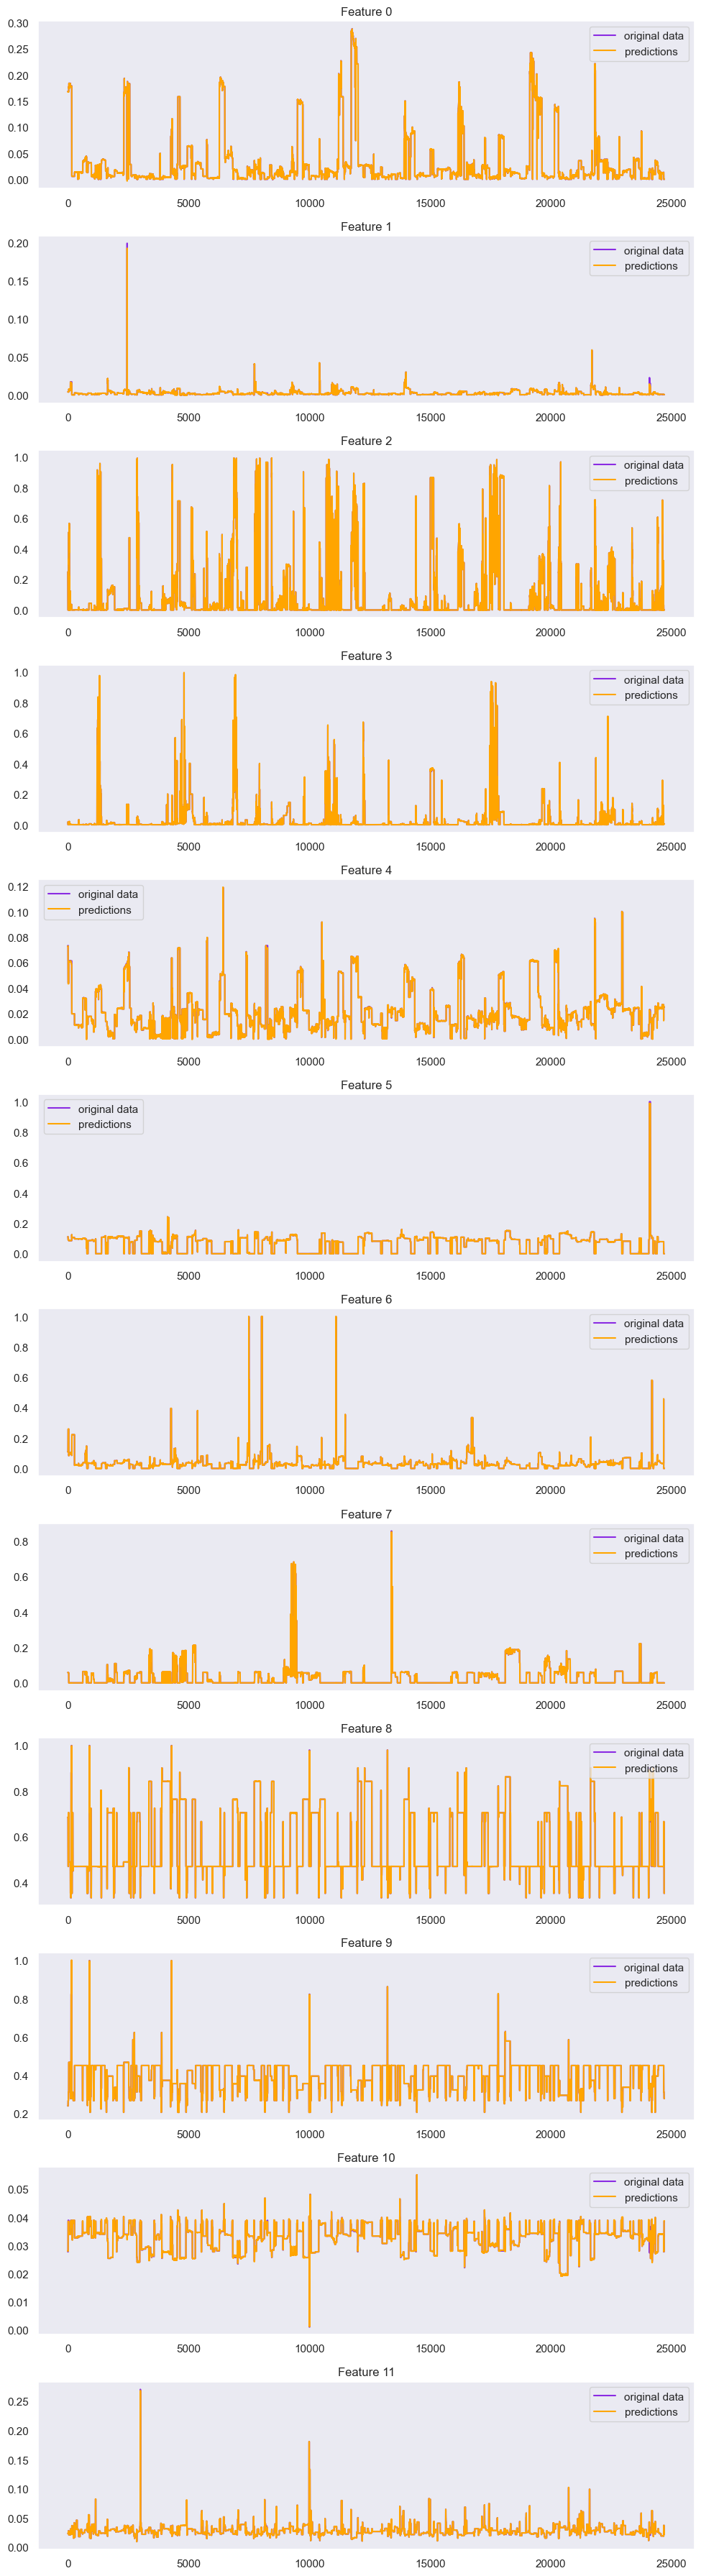

Epoch: 81  train loss: 0.00015163429868804694  val loss: 7.620413157029724e-05  time: 150.9544653892517 


Epoch: 82  train loss: 0.00015136343540141044  val loss: 9.513242200317514e-05  time: 150.9601855278015 


Epoch: 83  train loss: 0.00014724959527024516  val loss: 6.94938301980064e-05  time: 150.49784469604492 


Epoch: 84  train loss: 0.00015259624773297117  val loss: 0.00023776832193229635  time: 151.07389903068542 


Epoch: 85  train loss: 0.00014564433620049992  val loss: 0.000544149369446466  time: 151.44287967681885 


Epoch: 86  train loss: 0.0001472478145550819  val loss: 5.1310341798528034e-05  time: 150.384827375412 


Epoch: 87  train loss: 0.00015006081498222557  val loss: 9.77706309661986e-05  time: 151.19952511787415 


Epoch: 88  train loss: 0.0001371501139200417  val loss: 7.487019395178704e-05  time: 151.1420977115631 


Epoch: 89  train loss: 0.00014550193691841034  val loss: 0.00010229552016063314  time: 151.70581769943237 


Epoch: 90  train loss: 0.0001455776931822786  val loss: 9.227714844120708e-05  time: 151.47417402267456 


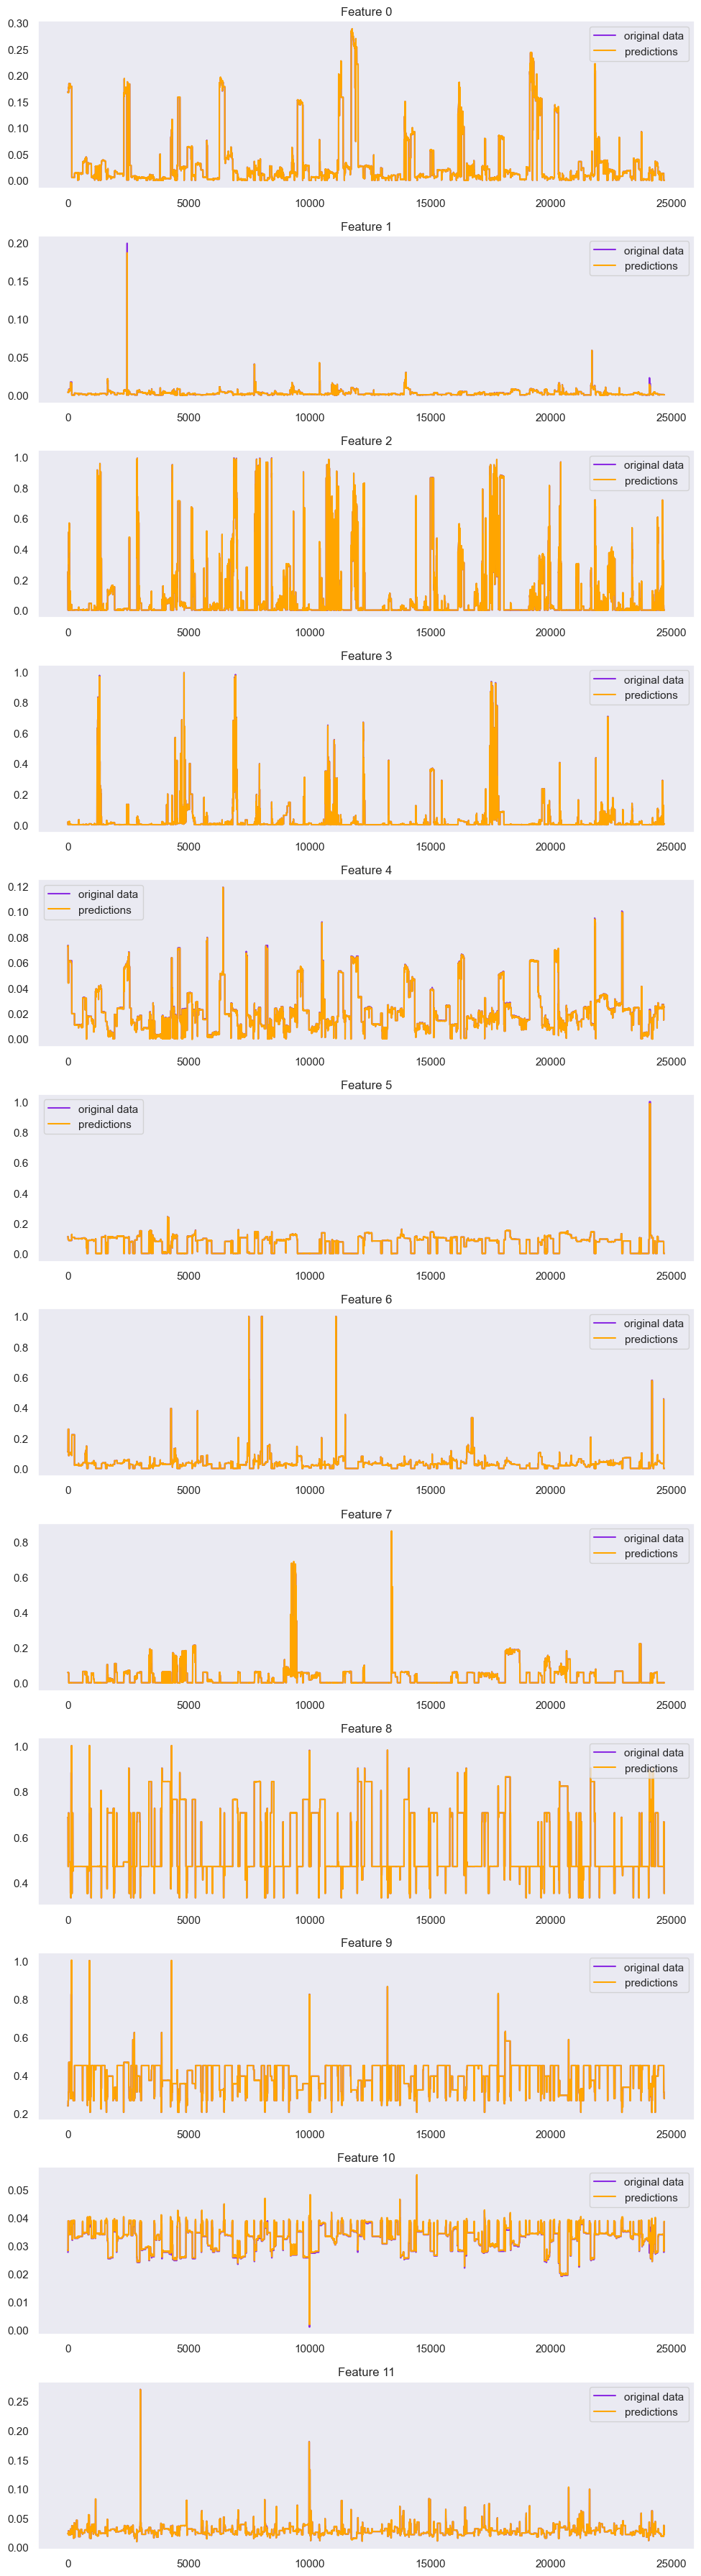

Epoch: 91  train loss: 0.00014304053908414162  val loss: 0.0001650657682902434  time: 152.09396648406982 


Epoch: 92  train loss: 0.0001424392729701746  val loss: 6.928360533910154e-05  time: 151.27633452415466 


Epoch: 93  train loss: 0.00013856120329435524  val loss: 0.00013121417573246725  time: 150.9579906463623 


Epoch: 94  train loss: 0.00013342114641227453  val loss: 0.00010705411009651617  time: 152.04139804840088 


Epoch: 95  train loss: 0.00013976944449607093  val loss: 0.0002534307986887312  time: 152.51659178733826 


Early stopping at epoch 96


In [27]:
model, history = train_model(model, train_loader,val_loader , args.epoch, n_features, args)

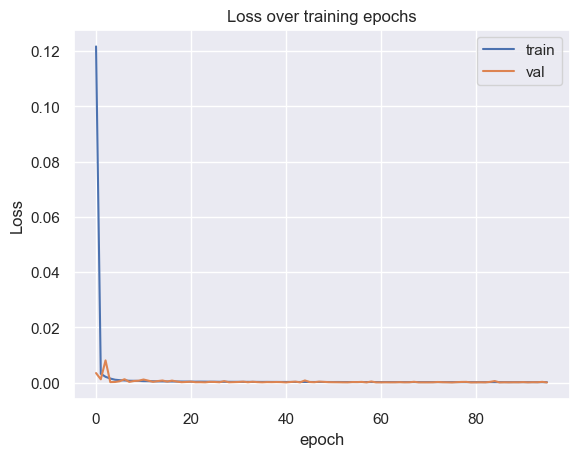

In [28]:
sns.set(style='dark')
plt.plot(history['train'])
plt.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('epoch')
# plt.ylim(0, 1)
plt.title('Loss over training epochs')
plt.legend(['train','val'])
plt.grid()
plt.savefig('losses.png', dpi=300)
plt.show();

In [29]:
MODEL_PATH = 'lstmae.pth'
torch.save(model, MODEL_PATH)

In [16]:
model = torch.load('lstmae.pth')
model = model.to(args.device)
model

LSTM_AUTO_ENCODER(
  (encoder): Encoder(
    (lstm1): LSTM(12, 256, batch_first=True)
    (lstm2): LSTM(256, 128, batch_first=True)
  )
  (decoder): Decoder(
    (lstm1): LSTM(128, 128, batch_first=True)
    (lstm2): LSTM(128, 256, batch_first=True)
    (output_layer): Linear(in_features=256, out_features=12, bias=True)
  )
)

In [17]:
class Create_dataset(Dataset):
    def __init__(self, data, seq_len=1, batch_size=1):
        self.data = data
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.n_samples, self.n_features = self.data.shape
        self.dataset = self.create_dataset(self.data, batch_size)

    def create_dataset(self, data, batch_size):
        sequences = []
        for i in range(len(data) - self.seq_len + 1):
            sequence = data.iloc[i:i+self.seq_len].values.astype(np.float32)
            sequences.append(torch.from_numpy(sequence))
        return DataLoader(sequences, batch_size=batch_size, shuffle=False)

    def __getitem__(self, index):
        return self.data.iloc[index]

    def __len__(self):
        return len(self.data) - self.seq_len + 1

In [18]:
class encdataset(Dataset):
    def __init__(self, data, seq_len=1, batch_size=1):
        # data load
        self.data = data
        self.features = self.data.values.astype(np.float32)
        self.n_samples, self.n_features = self.data.shape
        self.seq_len = seq_len
        self.train_df = self.data[0:576000]
        self.val_df = self.data[576000:]
        
        # создание датасета
        self.train_dataset = self.create_dataset(self.train_df, batch_size)
        self.val_dataset = self.create_dataset(self.val_df, batch_size)

    def create_dataset(self, data, batch_size):
        sequences = []
        for i in range(len(data) - self.seq_len + 1):
            sequence = data[i:i+self.seq_len].values  # Изменение здесь
            sequences.append(torch.from_numpy(sequence))
        dataset = DataLoader(sequences, batch_size=batch_size, shuffle=False)
        return dataset

    def __getitem__(self, index):
        return self.data.iloc[index]

    def __len__(self):
        return self.n_samples


In [19]:
df.head()

0         1      2        3         4         5         6    7   \
0  0.012844  0.001599  0.001  0.00042  0.018364  0.084681  0.026065  0.0   
1  0.012844  0.001599  0.001  0.00042  0.018364  0.084681  0.026065  0.0   
2  0.012844  0.001599  0.001  0.00042  0.018364  0.084681  0.026065  0.0   
3  0.012844  0.001599  0.001  0.00042  0.018364  0.084681  0.026065  0.0   
4  0.012844  0.001599  0.001  0.00042  0.018364  0.084681  0.026065  0.0   

         8         9         10        11  
0  0.470588  0.267261  0.038271  0.026556  
1  0.470588  0.267261  0.038271  0.026556  
2  0.470588  0.267261  0.038271  0.026556  
3  0.470588  0.267261  0.038271  0.026556  
4  0.470588  0.267261  0.038271  0.026556

In [20]:
dataset = encdataset(df)
train_loader = dataset.train_dataset
val_loader = dataset.val_dataset
seq_len = dataset.seq_len
n_features = dataset.n_features

In [21]:
anomaly = Create_dataset(anom)
anomaly_loader=anomaly.dataset

In [22]:
anomaly_loader

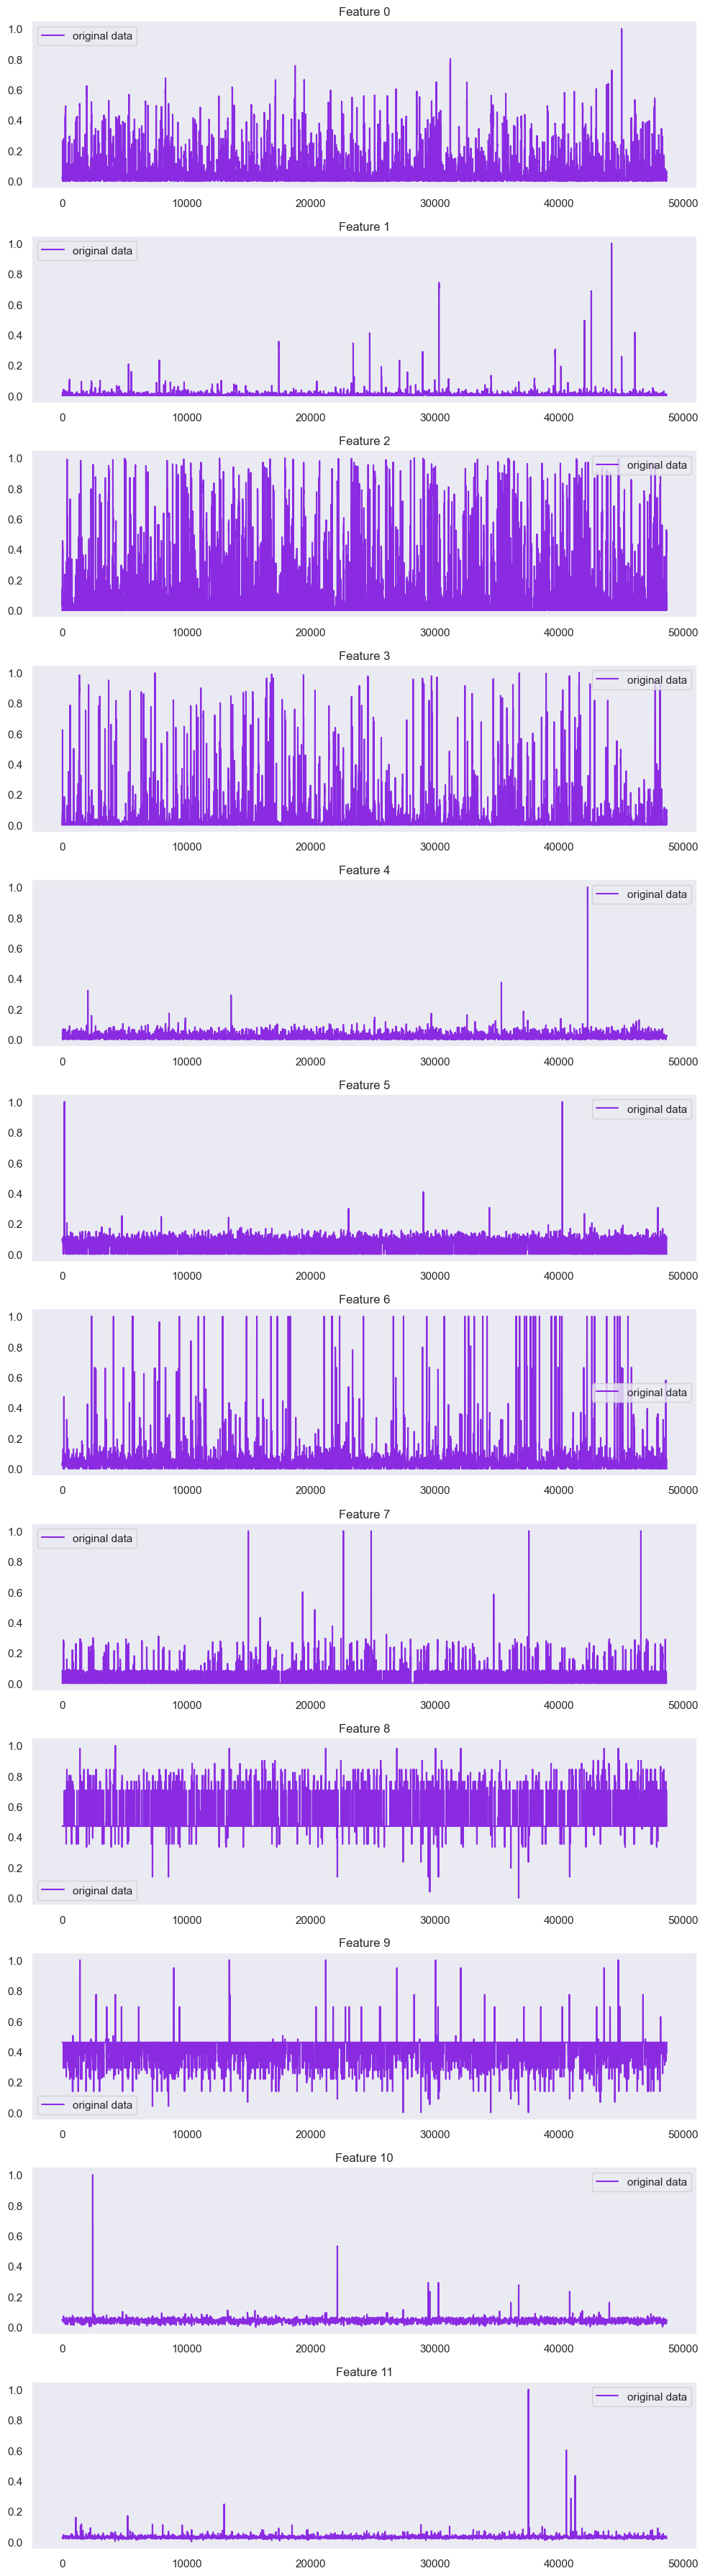

In [23]:
# 1. Извлечь данные из train_loader в виде numpy массива
anom_data = []
for batch in anomaly_loader:
    batch = batch.squeeze(1)  # убираем лишнее измерение
    batch = batch.numpy()  # преобразуем в numpy array
    for seq in batch:
        anom_data.append(seq)
anom_data = np.array(anom_data)

# 2. Перестроить данные в подходящий формат для построения графиков
anom_data = anom_data.reshape(-1, seq_len, n_features)

# 3. Создать подграфики для каждой фичи
fig, axs = plt.subplots(n_features, 1, figsize=(10, n_features * 3))

# 4. Построить график для каждой фичи
for i in range(n_features):
    line, = axs[i].plot(anom_data[:, 0, i], color='blueviolet', label='original data')
    for j in range(1, seq_len):
        axs[i].plot(anom_data[:, j, i], color='blueviolet')
    axs[i].set_title(f'Feature {i}')
    axs[i].legend(handles=[line])  # Добавить легенду

plt.tight_layout()
plt.show()

In [24]:
def predict(model, dataset):
    predictions, losses = [], []
    criterion = nn.MSELoss(reduction='sum').to(args.device)

    with torch.no_grad():
        model = model.eval()
        for seq_true in dataset:
            seq_true = seq_true.to(device=args.device)
            seq_pred = model(seq_true)

            loss = criterion(seq_pred, seq_true)

            predictions.append(seq_pred.cpu().numpy().flatten())
            losses.append(loss.item())
    return predictions, losses

d:\anaconda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


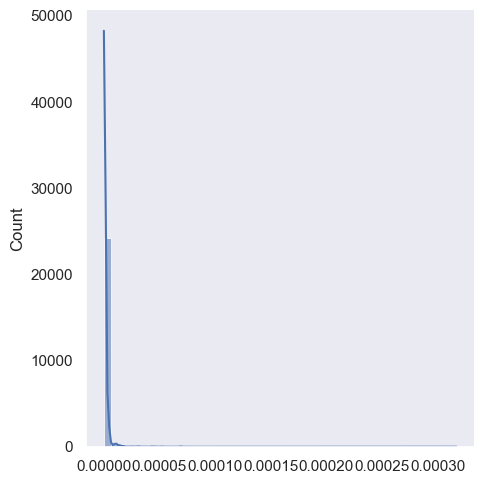

In [25]:
val_pred, val_losses = predict(model,val_loader)
sns.displot(val_losses, bins=50, kde=True);
plt.savefig('hist_val_losses.png', dpi=300)

d:\anaconda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


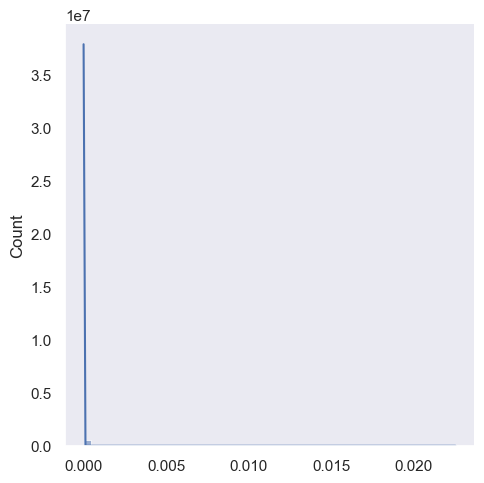

In [26]:
train_pred, train_losses = predict(model,train_loader)
sns.displot(train_losses, bins=50, kde=True);

d:\anaconda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


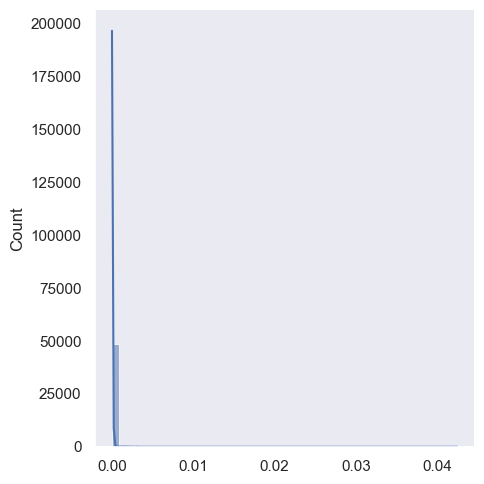

In [27]:
anom_pred, anom_losses = predict(model,anomaly_loader)
sns.displot(anom_losses, bins=50, kde=True);
plt.savefig('hist_anom_losses.png', dpi=300)

In [28]:
len(anom_losses)+len(val_losses)

73368

In [60]:
Threshold = 0.3e-6

In [61]:
corect_train= sum(l<= Threshold for l in train_losses)
print(f'Correct normal predictions: {corect_train}/{len(train_loader)}')
detected_train=corect_train/len(train_loader)
print(f'correct detected normal: {detected_train}')
corect_normal= sum(l<= Threshold for l in val_losses)
print(f'Correct normal predictions: {corect_normal}/{len(val_loader)}')
detected_normal=corect_normal/len(val_loader)
print(f'correct detected normal: {detected_normal}')
corect_anomaly= sum(l> Threshold for l in anom_losses)
print(f'Correct anomaly predictions: {corect_anomaly}/{len(anomaly_loader)}')
detected_anomaly=corect_anomaly/len(anomaly_loader)
print(f'correct detected anomaly: {detected_anomaly}')

Correct normal predictions: 257878/576000
correct detected normal: 0.44770486111111113
Correct normal predictions: 11035/24701
correct detected normal: 0.4467430468402089
Correct anomaly predictions: 36429/48667
correct detected anomaly: 0.7485359689317197


In [62]:
th=np.arange( 1e-7,1e-5,1e-10)
th.shape

(99000,)

In [63]:
corect_normal= sum(l<= th for l in val_losses)
print(f'Correct normal predictions: {corect_normal}/{len(val_loader)}')
detected_normal=corect_normal/len(val_loader)
print(f'correct detected normal: {detected_normal}')
corect_anomaly= sum(l> th for l in anom_losses)
print(f'Correct anomaly predictions: {corect_anomaly}/{len(anomaly_loader)}')
detected_anomaly=corect_anomaly/len(anomaly_loader)
print(f'correct detected anomaly: {detected_anomaly}')

Correct normal predictions: [  786   805   832 ... 24277 24277 24277]/24701
correct detected normal: [0.03182057 0.03258977 0.03368285 ... 0.9828347  0.9828347  0.9828347 ]
Correct anomaly predictions: [48466 48466 48464 ...  3033  3033  3033]/48667
correct detected anomaly: [0.99586989 0.99586989 0.9958288  ... 0.06232149 0.06232149 0.06232149]


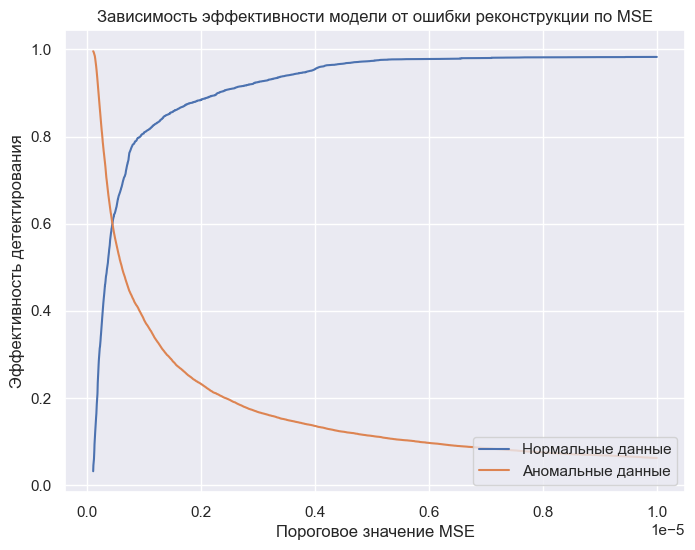

In [64]:
sns.set(style='dark')
plt.figure(figsize=(8,6))
plt.plot(th ,detected_normal)
plt.plot(th ,detected_anomaly)
plt.ylabel('Эффективность детектирования')
plt.xlabel('Пороговое значение MSE')
# plt.ylim(0, 1)
plt.title('Зависимость эффективности модели от ошибки реконструкции по MSE')
plt.legend(['Нормальные данные','Аномальные данные'], loc='lower right')
plt.grid()
plt.savefig('threshhold.png', dpi=300)
plt.show();

In [34]:
df['Failure']=0
anom['Failure']=1

In [35]:
combined_df = np.concatenate((df[576000:], anom), axis=0)

In [36]:
combined_df = pd.DataFrame(combined_df, columns=df.columns)

In [37]:
combined_df.shape

(73368, 13)

In [38]:
X=combined_df.drop(['Failure'], axis=1)
y=combined_df['Failure']

In [39]:
combo = Create_dataset(X)
combo_loader=combo.dataset

In [40]:
losses=val_losses+ anom_losses

In [41]:
score = pd.DataFrame(index = X.index)
score['Loss'] = losses
score['Threshold'] = Threshold
score['Anomaly'] = score['Loss'] > score['Threshold']

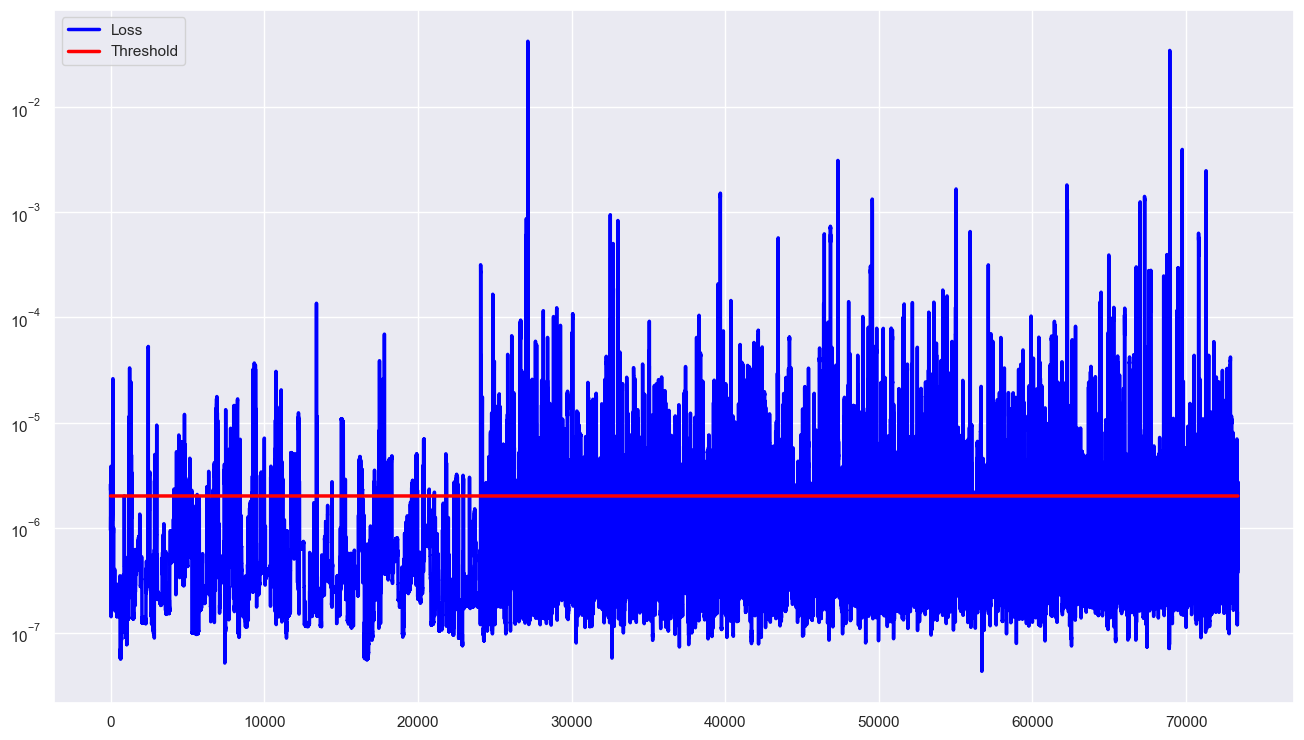

In [42]:
sns.set(style='dark')
score.plot(logy=True, figsize=(16,9), color=['blue','red'],linewidth=2.5)
plt.savefig('score_plot.png', dpi=300)
plt.grid()
# Отображение графика
plt.show()

In [43]:
from sklearn.metrics import  roc_auc_score, classification_report, accuracy_score, f1_score, precision_score, recall_score

In [44]:
Threshold=0.03e-5

In [45]:
def metrics(y_true,y_pred):
    acc=accuracy_score(y_true, y_pred)
    f1=f1_score(y_true, y_pred, average='binary')
    roc_auc=roc_auc_score(y_true, y_pred)
    precision=precision_score(y_true, y_pred)
    recall=recall_score(y_true, y_pred)
    corect_normal= sum(l<= Threshold for l in val_losses)
    print(f'Correct normal predictions: {corect_normal}/{len(val_loader)}')
    detected_normal=corect_normal/len(val_loader)
    print(f'correct detected normal: {detected_normal}')
    corect_anomaly= sum(l> Threshold for l in anom_losses)
    print(f'Correct anomaly predictions: {corect_anomaly}/{len(anomaly_loader)}')
    detected_anomaly=corect_anomaly/len(anomaly_loader)
    print(f'correct detected anomaly: {detected_anomaly}')
        # Создание DataFrame
    metrics_df = pd.DataFrame({
        'Метрика': ['Recall', 'Precision', 'F1', 'roc_auc', 'accuracy', 'detected normal', 'detected anomaly'],
        'Значение': [recall, precision, f1, roc_auc, acc, detected_normal, detected_anomaly]
    })

    # # Сохранение DataFrame в CSV
    metrics_df.to_csv('metrics.csv', index=False)
    return metrics_df

In [46]:
score.head()

Loss  Threshold  Anomaly
0  2.271750e-06   0.000002     True
1  2.593988e-06   0.000002     True
2  9.422272e-07   0.000002    False
3  1.029695e-06   0.000002    False
4  1.029695e-06   0.000002    False

In [47]:
y.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Failure, dtype: float64

In [48]:
y.shape

(73368,)

In [49]:
score['Anomaly'].shape

(73368,)

In [50]:
score['Anomaly']=score['Anomaly'].astype(int)

In [51]:
metrics(y, score['Anomaly'])


Correct normal predictions: 11035/24701
correct detected normal: 0.4467430468402089
Correct anomaly predictions: 36429/48667
correct detected anomaly: 0.7485359689317197


Метрика  Значение
0            Recall  0.231594
1         Precision  0.798399
2                F1  0.359041
3           roc_auc  0.558188
4          accuracy  0.451505
5   detected normal  0.446743
6  detected anomaly  0.748536

In [52]:
score.head()

Loss  Threshold  Anomaly
0  2.271750e-06   0.000002        1
1  2.593988e-06   0.000002        1
2  9.422272e-07   0.000002        0
3  1.029695e-06   0.000002        0
4  1.029695e-06   0.000002        0

In [53]:
combo_data_np = torch.cat([batch for batch in combo_loader], dim=0).detach().cpu().numpy()

# 2. Перестроить данные в подходящий формат для построения графиков
combo_data_np = combo_data_np.reshape(-1, seq_len, n_features)

# 3. Получить предсказания модели
preds = []
with torch.no_grad():
    model = model.eval()
    for seq_true in combo_loader:
        seq_true = seq_true.to(args.device)
        seq_true = seq_true.reshape((-1, seq_len, n_features))

        seq_pred = model(seq_true)
        preds.append(seq_pred.cpu().numpy())
preds = np.concatenate(preds, axis=0)

# 4. Создать подграфики для каждой фичи
fig, axs = plt.subplots(n_features, 1, figsize=(10, n_features * 3))

# 5. Построить график для каждой фичи
for i in range(n_features):
    

    line2, = axs[i].plot(preds[:, 0, i], color='orange', label='predictions')
    line1, = axs[i].plot(combo_data_np[:, 0, i], color='blueviolet', label='original data')
    for j in range(1, seq_len):
        axs[i].plot(combo_data_np[:, j, i], color='blueviolet')
        axs[i].plot(preds[:, j, i], color='orange')
    axs[i].set_title(f'Feature {i}')
    axs[i].legend(handles=[line1, line2])
# plt.savefig('preds/original 3d.png', dpi=300)
plt.tight_layout()

plt.show()


KeyboardInterrupt: 